# Warming trends of an Australian Marine Park

**What does this notebook do?** 
This notebook demonstrates how to generate and plot SST time-series of various temporal resolutions for a Australian Marine Park, and to determine their warming trends.

**Requirements** 
You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

module use /g/data/v10/public/modules/modulefiles

module load dea

If you find an error or bug in this notebook, please either create an 'Issue' in the Github repository, or fix it yourself and create a 'Pull' request to contribute the updated notebook back into the repository (See the repository README for instructions on creating a Pull request).

**Date:** last updated 30th, Jan, 2020

**Author:** Zhi Huang

**Import modules**

In [1]:
from datacube import Datacube
from datacube.storage.masking import mask_invalid_data
%matplotlib inline
import fiona
from shapely import geometry
from datacube.utils import geometry
import matplotlib.pyplot as plt
import geopandas as gpd
from rasterstats import zonal_stats
from affine import Affine
from datacube.helpers import write_geotiff
import pandas as pd
from datetime import datetime
import rasterio.features
import numpy as np

**Specify a development database to connect to. It is on a different database server agdcstaging-db.nci.org.au, which means that your ~/.pgpass file will need to specify a password to connect to it as well.**

In [2]:
dc = Datacube(config='/g/data/u46/users/dsg547/modis_oc.conf')

**The only product in this database is the daily ocean colour data between July 2002 and July 2019.**

In [3]:
dc.list_products()

,name,description,lon,lat,instrument,format,product_type,platform,label,time,creation_time,crs,resolution,tile_size,spatial_dimensions
id,,,,,,,,,,,,,,,
5,modis_oc_1d,MODIS Ocean Cover Daily,None,None,None,None,modis_oc_1d,MODIS,None,None,None,EPSG:4326,"(-0.01, 0.01)",None,"(latitude, longitude)"


**plot the AMP shapefile**

PROJCS["GDA94 / Australian Albers",GEOGCS["GDA94",DATUM["Geocentric_Datum_of_Australia_1994",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],TOWGS84[0,0,0,0,0,0,0],AUTHORITY["EPSG","6283"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4283"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["standard_parallel_1",-18],PARAMETER["standard_parallel_2",-36],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",132],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","3577"]]


<Figure size 432x288 with 0 Axes>

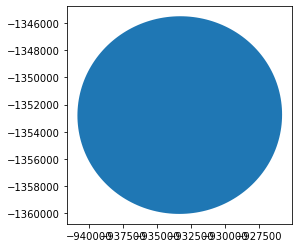

In [3]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'

#open the polygon
with fiona.open(poly_path) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

print(crs)
#plot polygon to check it looks ok
plt.clf()
shape_plot = gpd.read_file(poly_path)
shape_plot.plot()

plt.show()


**load sst data for the AMP**

In [4]:
query = {'geopolygon': geom,
         'output_crs': 'EPSG:3577',
         'resolution': (-1300,1300)
         }

In [5]:
time1 = datetime.now()
data = dc.load(product='modis_oc_1d', measurements=(['sst']), **query)
time2 = datetime.now()
diff = time2 - time1
print('took',diff, 'to finish')

took 0:17:23.199222 to finish


**create a mask for the area covered by the AMP polygon**

In [6]:
mask = rasterio.features.geometry_mask([geom.to_crs(data.geobox.crs) for geoms in [geom]],
                                           out_shape=data.geobox.shape,
                                           transform=data.geobox.affine,
                                           all_touched=False,
                                           invert=True)
data = data.where(mask)

In [7]:
data = mask_invalid_data(data)

In [8]:
# note the time dimension: 6214
data

<xarray.Dataset>
Dimensions:  (time: 6214, x: 12, y: 13)
Coordinates:
  * time     (time) datetime64[ns] 2002-07-04T11:59:59.999999 ... 2019-07-22T11:59:59.999999
  * y        (y) float64 -1.345e+06 -1.346e+06 ... -1.359e+06 -1.36e+06
  * x        (x) float64 -9.406e+05 -9.392e+05 ... -9.276e+05 -9.262e+05
Data variables:
    sst      (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    crs:      EPSG:3577

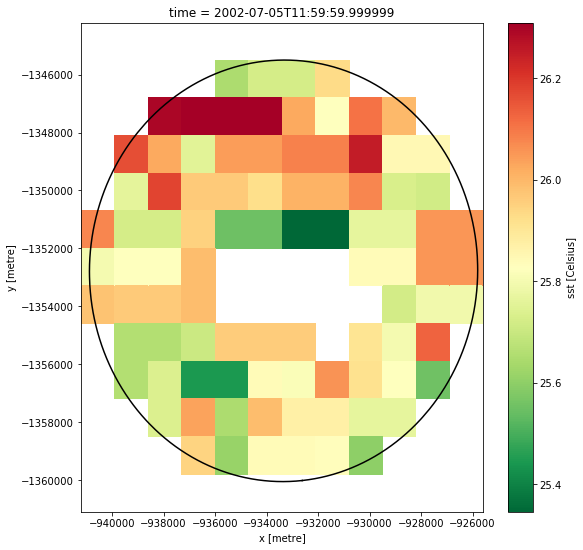

In [9]:
#plot polygon to check it looks ok

import shapefile as shpf
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
LH = shpf.Reader(poly_path)
plt.figure(figsize=(9,9))

for shape in LH.shapeRecords():
    x = [i[0] for i in shape.shape.points[:]]
    y = [i[1] for i in shape.shape.points[:]]
    plt.plot(x, y, 'k')
data.sst[1].plot(cmap='RdYlGn_r')

**the pad function for linear interpolation of missing data in a time series**

In [10]:
import numpy as np
import scipy.ndimage as ndimage
def pad(data, maxPadLength=False):
    '''

    Linearly interpolate over missing data (NaNs) in a time series.

    Inputs:

      data	     Time series [1D numpy array]
      maxPadLength   Specifies the maximum length over which to interpolate,
                     i.e., any consecutive blocks of NaNs with length greater
                     than maxPadLength will be left as NaN. Set as an integer.
                     maxPadLength=False (default) interpolates over all NaNs.

    Written by Eric Oliver, Institue for Marine and Antarctic Studies, University of Tasmania, Jun 2015

    '''
    data_padded = data.copy()
    bad_indexes = np.isnan(data)
    good_indexes = np.logical_not(bad_indexes)
    good_data = data[good_indexes]
    interpolated = np.interp(bad_indexes.nonzero()[0], good_indexes.nonzero()[0], good_data)
    data_padded[bad_indexes] = interpolated
    if maxPadLength:
        blocks, n_blocks = ndimage.label(np.isnan(data))
        for bl in range(1, n_blocks+1):
            if (blocks==bl).sum() > maxPadLength:
                data_padded[blocks==bl] = np.nan

    return data_padded


In [11]:
data.affine

Affine(1300.0, 0.0, -941200.0,
       0.0, -1300.0, -1344200.0)

## conduct zonal statstists

In [12]:
stats = zonal_stats(poly_path,data.sst[1].data,affine=data.affine)

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/rasterstats/io.py:300: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


In [13]:
stats

[{'min': 25.344999313354492,
  'max': 26.309999465942383,
  'mean': 25.874619483947754,
  'count': 92}]

In [14]:
stats1 = zonal_stats(poly_path,data.sst[1].data,affine=data.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)

In [15]:
stats1[0]['properties']

OrderedDict([('MPA_NAME', 'Cartier Island'),
             ('network', 'North-west'),
             ('area', 172.374498774),
             ('count', 92),
             ('min', 25.344999313354492),
             ('max', 26.309999465942383),
             ('mean', 25.874619483947754),
             ('sum', 2380.4649925231934),
             ('std', 0.20326046538979875),
             ('median', 25.850000381469727),
             ('range', 0.9650001525878906)])

## list results as table

In [16]:
import pandas as pd
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
propertiesList = []
for f in stats1:
    propertiesList.append(f['properties'])
df = pd.DataFrame(propertiesList)

In [17]:
df

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range
0,Cartier Island,North-west,172.374499,92,25.344999,26.309999,25.874619,2380.464993,0.20326,25.85,0.965


**conduct zonal statistics for all SST data (data), convert the results to a DataFrame**

**in doing so, we obtained the daily SST time-series of the AMP**

In [18]:
poly_path = '/home/547/zxh547/dea-notebooks/shapefiles/Cartier_Island.shp'
i = 0
propertiesList = []
dateList = []
while i < data['sst'].time.size:
    date = str(data['sst'].time[i].data)[:10]
    print(date)
    dateList.append(date)
    sst = data.sst[i].data
    stats = zonal_stats(poly_path,sst,affine=data.affine,stats=['min','max','mean','range','median','std','sum','count'],geojson_out=True)
    
    propertiesList.append(stats[0]['properties'])
    
    
    i = i + 1
sstDF = pd.DataFrame(propertiesList)
sstDF['date']=dateList
sstDF.set_index('date',inplace=True)

2002-07-04
2002-07-05
2002-07-06
2002-07-07
2002-07-08
2002-07-09
2002-07-10
2002-07-11
2002-07-12
2002-07-13
2002-07-14
2002-07-15
2002-07-16
2002-07-17
2002-07-18
2002-07-19
2002-07-20
2002-07-21
2002-07-22
2002-07-23
2002-07-24
2002-07-25
2002-07-26
2002-07-27
2002-07-28
2002-07-29
2002-08-07
2002-08-08
2002-08-09
2002-08-10
2002-08-11
2002-08-12
2002-08-13
2002-08-14
2002-08-15
2002-08-16
2002-08-17
2002-08-18
2002-08-19
2002-08-20
2002-08-21
2002-08-22
2002-08-23
2002-08-24
2002-08-25
2002-08-26
2002-08-27
2002-08-28
2002-08-29
2002-08-30
2002-08-31
2002-09-01
2002-09-02
2002-09-03
2002-09-04
2002-09-05
2002-09-06
2002-09-07
2002-09-08
2002-09-09
2002-09-10
2002-09-11
2002-09-12
2002-09-13
2002-09-14
2002-09-15
2002-09-16
2002-09-17
2002-09-18
2002-09-19
2002-09-20
2002-09-21
2002-09-22
2002-09-23
2002-09-24
2002-09-25
2002-09-26
2002-09-27
2002-09-28
2002-09-29
2002-09-30
2002-10-01
2002-10-02
2002-10-03
2002-10-04
2002-10-05
2002-10-06
2002-10-07
2002-10-08
2002-10-09
2002-10-10

2004-07-26
2004-07-27
2004-07-28
2004-07-29
2004-07-30
2004-07-31
2004-08-01
2004-08-02
2004-08-03
2004-08-04
2004-08-05
2004-08-06
2004-08-07
2004-08-08
2004-08-09
2004-08-10
2004-08-11
2004-08-12
2004-08-13
2004-08-14
2004-08-15
2004-08-16
2004-08-17
2004-08-18
2004-08-19
2004-08-20
2004-08-21
2004-08-22
2004-08-23
2004-08-24
2004-08-25
2004-08-26
2004-08-27
2004-08-28
2004-08-29
2004-08-30
2004-08-31
2004-09-01
2004-09-02
2004-09-03
2004-09-04
2004-09-05
2004-09-06
2004-09-07
2004-09-08
2004-09-09
2004-09-10
2004-09-11
2004-09-12
2004-09-13
2004-09-14
2004-09-15
2004-09-16
2004-09-17
2004-09-18
2004-09-19
2004-09-20
2004-09-21
2004-09-22
2004-09-23
2004-09-24
2004-09-25
2004-09-26
2004-09-27
2004-09-28
2004-09-29
2004-09-30
2004-10-01
2004-10-02
2004-10-03
2004-10-04
2004-10-05
2004-10-06
2004-10-07
2004-10-08
2004-10-09
2004-10-10
2004-10-11
2004-10-12
2004-10-13
2004-10-14
2004-10-15
2004-10-16
2004-10-17
2004-10-18
2004-10-19
2004-10-20
2004-10-21
2004-10-22
2004-10-23
2004-10-24

2006-08-12
2006-08-13
2006-08-14
2006-08-15
2006-08-16
2006-08-17
2006-08-18
2006-08-19
2006-08-20
2006-08-21
2006-08-22
2006-08-23
2006-08-24
2006-08-25
2006-08-26
2006-08-27
2006-08-28
2006-08-29
2006-08-30
2006-08-31
2006-09-01
2006-09-02
2006-09-03
2006-09-04
2006-09-05
2006-09-06
2006-09-07
2006-09-08
2006-09-09
2006-09-10
2006-09-11
2006-09-12
2006-09-13
2006-09-14
2006-09-15
2006-09-16
2006-09-17
2006-09-18
2006-09-19
2006-09-20
2006-09-21
2006-09-22
2006-09-23
2006-09-24
2006-09-25
2006-09-26
2006-09-27
2006-09-28
2006-09-29
2006-09-30
2006-10-01
2006-10-02
2006-10-03
2006-10-04
2006-10-05
2006-10-06
2006-10-07
2006-10-08
2006-10-09
2006-10-10
2006-10-11
2006-10-12
2006-10-13
2006-10-14
2006-10-15
2006-10-16
2006-10-17
2006-10-18
2006-10-19
2006-10-20
2006-10-21
2006-10-22
2006-10-23
2006-10-24
2006-10-25
2006-10-26
2006-10-27
2006-10-28
2006-10-29
2006-10-30
2006-10-31
2006-11-01
2006-11-02
2006-11-03
2006-11-04
2006-11-05
2006-11-06
2006-11-07
2006-11-08
2006-11-09
2006-11-10

2008-08-31
2008-09-01
2008-09-02
2008-09-03
2008-09-04
2008-09-05
2008-09-06
2008-09-07
2008-09-08
2008-09-09
2008-09-10
2008-09-11
2008-09-12
2008-09-13
2008-09-14
2008-09-15
2008-09-16
2008-09-17
2008-09-18
2008-09-19
2008-09-20
2008-09-21
2008-09-22
2008-09-23
2008-09-24
2008-09-25
2008-09-26
2008-09-27
2008-09-28
2008-09-29
2008-09-30
2008-10-01
2008-10-02
2008-10-03
2008-10-04
2008-10-05
2008-10-06
2008-10-07
2008-10-08
2008-10-09
2008-10-10
2008-10-11
2008-10-12
2008-10-13
2008-10-14
2008-10-15
2008-10-16
2008-10-17
2008-10-18
2008-10-19
2008-10-20
2008-10-21
2008-10-22
2008-10-23
2008-10-24
2008-10-25
2008-10-26
2008-10-27
2008-10-28
2008-10-29
2008-10-30
2008-10-31
2008-11-01
2008-11-02
2008-11-03
2008-11-04
2008-11-05
2008-11-06
2008-11-07
2008-11-08
2008-11-09
2008-11-10
2008-11-11
2008-11-12
2008-11-13
2008-11-14
2008-11-15
2008-11-16
2008-11-17
2008-11-18
2008-11-19
2008-11-20
2008-11-21
2008-11-22
2008-11-23
2008-11-24
2008-11-25
2008-11-26
2008-11-27
2008-11-28
2008-11-29

2010-09-17
2010-09-18
2010-09-19
2010-09-20
2010-09-21
2010-09-22
2010-09-23
2010-09-24
2010-09-25
2010-09-26
2010-09-27
2010-09-28
2010-09-29
2010-09-30
2010-10-01
2010-10-02
2010-10-03
2010-10-04
2010-10-05
2010-10-06
2010-10-07
2010-10-08
2010-10-09
2010-10-10
2010-10-11
2010-10-12
2010-10-13
2010-10-14
2010-10-15
2010-10-16
2010-10-17
2010-10-18
2010-10-19
2010-10-20
2010-10-21
2010-10-22
2010-10-23
2010-10-24
2010-10-25
2010-10-26
2010-10-27
2010-10-28
2010-10-29
2010-10-30
2010-10-31
2010-11-01
2010-11-02
2010-11-03
2010-11-04
2010-11-05
2010-11-06
2010-11-07
2010-11-08
2010-11-09
2010-11-10
2010-11-11
2010-11-12
2010-11-13
2010-11-14
2010-11-15
2010-11-16
2010-11-17
2010-11-18
2010-11-19
2010-11-20
2010-11-21
2010-11-22
2010-11-23
2010-11-24
2010-11-25
2010-11-26
2010-11-27
2010-11-28
2010-11-29
2010-11-30
2010-12-01
2010-12-02
2010-12-03
2010-12-04
2010-12-05
2010-12-06
2010-12-07
2010-12-08
2010-12-09
2010-12-10
2010-12-11
2010-12-12
2010-12-13
2010-12-14
2010-12-15
2010-12-16

2012-10-01
2012-10-02
2012-10-03
2012-10-04
2012-10-05
2012-10-06
2012-10-07
2012-10-08
2012-10-09
2012-10-10
2012-10-11
2012-10-12
2012-10-13
2012-10-14
2012-10-15
2012-10-16
2012-10-17
2012-10-18
2012-10-19
2012-10-20
2012-10-21
2012-10-22
2012-10-23
2012-10-24
2012-10-25
2012-10-26
2012-10-27
2012-10-28
2012-10-29
2012-10-30
2012-10-31
2012-11-01
2012-11-02
2012-11-03
2012-11-04
2012-11-05
2012-11-06
2012-11-07
2012-11-08
2012-11-09
2012-11-10
2012-11-11
2012-11-12
2012-11-13
2012-11-14
2012-11-15
2012-11-16
2012-11-17
2012-11-18
2012-11-19
2012-11-20
2012-11-21
2012-11-22
2012-11-23
2012-11-24
2012-11-25
2012-11-26
2012-11-27
2012-11-28
2012-11-29
2012-11-30
2012-12-01
2012-12-02
2012-12-03
2012-12-04
2012-12-05
2012-12-06
2012-12-07
2012-12-08
2012-12-09
2012-12-10
2012-12-11
2012-12-12
2012-12-13
2012-12-14
2012-12-15
2012-12-16
2012-12-17
2012-12-18
2012-12-19
2012-12-20
2012-12-21
2012-12-22
2012-12-23
2012-12-24
2012-12-25
2012-12-26
2012-12-27
2012-12-28
2012-12-29
2012-12-30

2014-10-22
2014-10-23
2014-10-24
2014-10-25
2014-10-26
2014-10-27
2014-10-28
2014-10-29
2014-10-30
2014-10-31
2014-11-01
2014-11-02
2014-11-03
2014-11-04
2014-11-05
2014-11-06
2014-11-07
2014-11-08
2014-11-09
2014-11-10
2014-11-11
2014-11-12
2014-11-13
2014-11-14
2014-11-15
2014-11-16
2014-11-17
2014-11-18
2014-11-19
2014-11-20
2014-11-21
2014-11-22
2014-11-23
2014-11-24
2014-11-25
2014-11-26
2014-11-27
2014-11-28
2014-11-29
2014-11-30
2014-12-01
2014-12-02
2014-12-03
2014-12-04
2014-12-05
2014-12-06
2014-12-07
2014-12-08
2014-12-09
2014-12-10
2014-12-11
2014-12-12
2014-12-13
2014-12-14
2014-12-15
2014-12-16
2014-12-17
2014-12-18
2014-12-19
2014-12-20
2014-12-21
2014-12-22
2014-12-23
2014-12-24
2014-12-25
2014-12-26
2014-12-27
2014-12-28
2014-12-29
2014-12-30
2014-12-31
2015-01-01
2015-01-02
2015-01-03
2015-01-04
2015-01-05
2015-01-06
2015-01-07
2015-01-08
2015-01-09
2015-01-10
2015-01-11
2015-01-12
2015-01-13
2015-01-14
2015-01-15
2015-01-16
2015-01-17
2015-01-18
2015-01-19
2015-01-20

2016-11-11
2016-11-12
2016-11-13
2016-11-14
2016-11-15
2016-11-16
2016-11-17
2016-11-18
2016-11-19
2016-11-20
2016-11-21
2016-11-22
2016-11-23
2016-11-24
2016-11-25
2016-11-26
2016-11-27
2016-11-28
2016-11-29
2016-11-30
2016-12-01
2016-12-02
2016-12-03
2016-12-04
2016-12-05
2016-12-06
2016-12-07
2016-12-08
2016-12-09
2016-12-10
2016-12-11
2016-12-12
2016-12-13
2016-12-14
2016-12-15
2016-12-16
2016-12-17
2016-12-18
2016-12-19
2016-12-20
2016-12-21
2016-12-22
2016-12-23
2016-12-24
2016-12-25
2016-12-26
2016-12-27
2016-12-28
2016-12-29
2016-12-30
2016-12-31
2017-01-01
2017-01-02
2017-01-03
2017-01-04
2017-01-05
2017-01-06
2017-01-07
2017-01-08
2017-01-09
2017-01-10
2017-01-11
2017-01-12
2017-01-13
2017-01-14
2017-01-15
2017-01-16
2017-01-17
2017-01-18
2017-01-19
2017-01-20
2017-01-21
2017-01-22
2017-01-23
2017-01-24
2017-01-25
2017-01-26
2017-01-27
2017-01-28
2017-01-29
2017-01-30
2017-01-31
2017-02-01
2017-02-02
2017-02-03
2017-02-04
2017-02-05
2017-02-06
2017-02-07
2017-02-08
2017-02-09

2018-11-27
2018-11-28
2018-11-29
2018-11-30
2018-12-01
2018-12-02
2018-12-03
2018-12-04
2018-12-05
2018-12-06
2018-12-07
2018-12-08
2018-12-09
2018-12-10
2018-12-11
2018-12-12
2018-12-13
2018-12-14
2018-12-15
2018-12-16
2018-12-17
2018-12-18
2018-12-19
2018-12-20
2018-12-21
2018-12-22
2018-12-23
2018-12-24
2018-12-25
2018-12-26
2018-12-27
2018-12-28
2018-12-29
2018-12-30
2018-12-31
2019-01-01
2019-01-02
2019-01-03
2019-01-04
2019-01-05
2019-01-06
2019-01-07
2019-01-08
2019-01-09
2019-01-10
2019-01-11
2019-01-12
2019-01-13
2019-01-14
2019-01-15
2019-01-16
2019-01-17
2019-01-18
2019-01-19
2019-01-20
2019-01-21
2019-01-22
2019-01-23
2019-01-24
2019-01-25
2019-01-26
2019-01-27
2019-01-28
2019-01-29
2019-01-30
2019-01-31
2019-02-01
2019-02-02
2019-02-03
2019-02-04
2019-02-05
2019-02-06
2019-02-07
2019-02-08
2019-02-09
2019-02-10
2019-02-11
2019-02-12
2019-02-13
2019-02-14
2019-02-15
2019-02-16
2019-02-17
2019-02-18
2019-02-19
2019-02-20
2019-02-21
2019-02-22
2019-02-23
2019-02-24
2019-02-25

In [14]:
sstDF.head(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range
date,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,100,26.605000,27.205000,26.917400,2691.740019,0.145534,26.910000,0.600000
2002-07-05,Cartier Island,North-west,172.374499,92,25.344999,26.309999,25.874619,2380.464993,0.203260,25.850000,0.965000
2002-07-06,Cartier Island,North-west,172.374499,96,26.379999,27.030001,26.698750,2563.080006,0.139280,26.702500,0.650002
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-07-08,Cartier Island,North-west,172.374499,96,25.895000,26.690001,26.308698,2525.635004,0.149365,26.297501,0.795000
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002-07-10,Cartier Island,North-west,172.374499,98,25.924999,26.725000,26.353980,2582.690004,0.158531,26.365000,0.800001
2002-07-11,Cartier Island,North-west,172.374499,98,25.985001,26.809999,26.338520,2581.174997,0.178426,26.290001,0.824999
2002-07-12,Cartier Island,North-west,172.374499,99,25.934999,26.555000,26.243182,2598.075005,0.161215,26.245001,0.620001


**plot the daily SST time series of mean, min and max for the AMP**

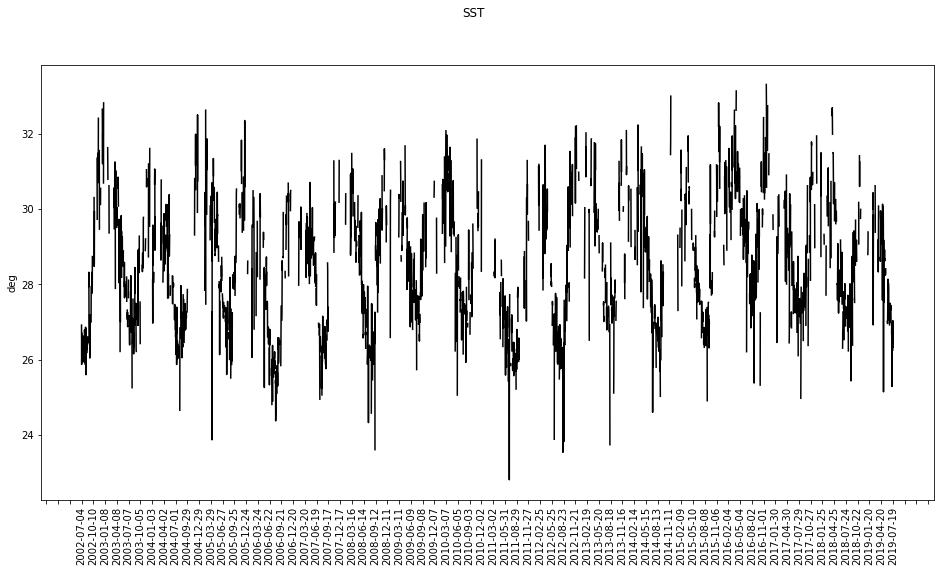

In [19]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(sstDF.index.values,sstDF['mean'].values,color='black')
#ax.plot(sstDF.index.values,sstDF['min'].values,color='blue')
#ax.plot(sstDF.index.values,sstDF['max'].values,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**apply interpolation on the daily mean, min and max SST time-series**

In [20]:
meanI = pad(sstDF['mean'].values,maxPadLength=False)
minI = pad(sstDF['min'].values,maxPadLength=False)
maxI = pad(sstDF['max'].values,maxPadLength=False)

sstDF['meanI'] = meanI
sstDF['minI'] = minI
sstDF['maxI'] = maxI

**plot the interploated daily time-series**

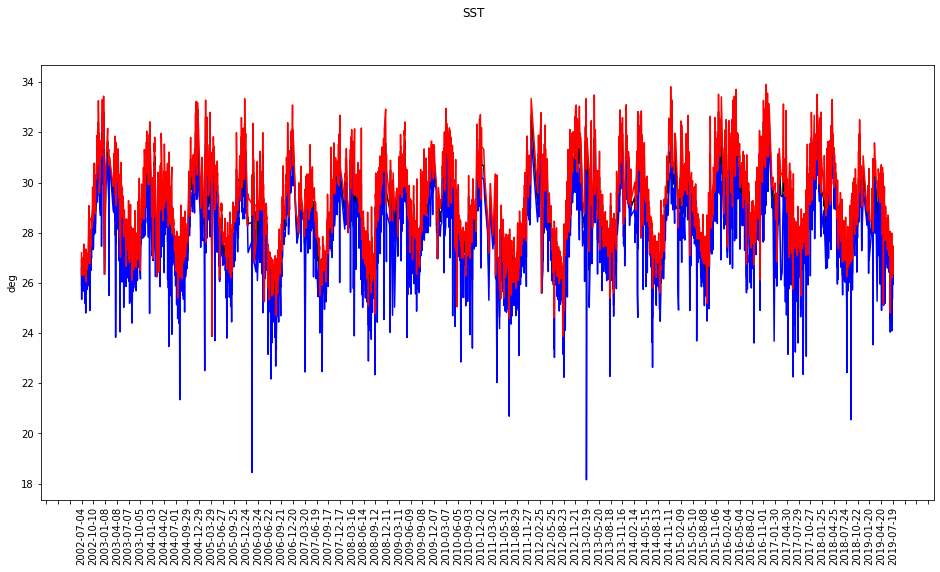

In [22]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(sstDF.index.values,sstDF['meanI'].values,color='black')
ax.plot(sstDF.index.values,sstDF['minI'].values,color='blue')
ax.plot(sstDF.index.values,sstDF['maxI'].values,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**plot and fit a linear trend line to the daily time-series**

                            OLS Regression Results                            
Dep. Variable:                  meanI   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     76.82
Date:                Mon, 24 Feb 2020   Prob (F-statistic):           2.38e-18
Time:                        10:13:42   Log-Likelihood:                -11676.
No. Observations:                6214   AIC:                         2.336e+04
Df Residuals:                    6212   BIC:                         2.337e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.4519      0.040    707.723      0.0

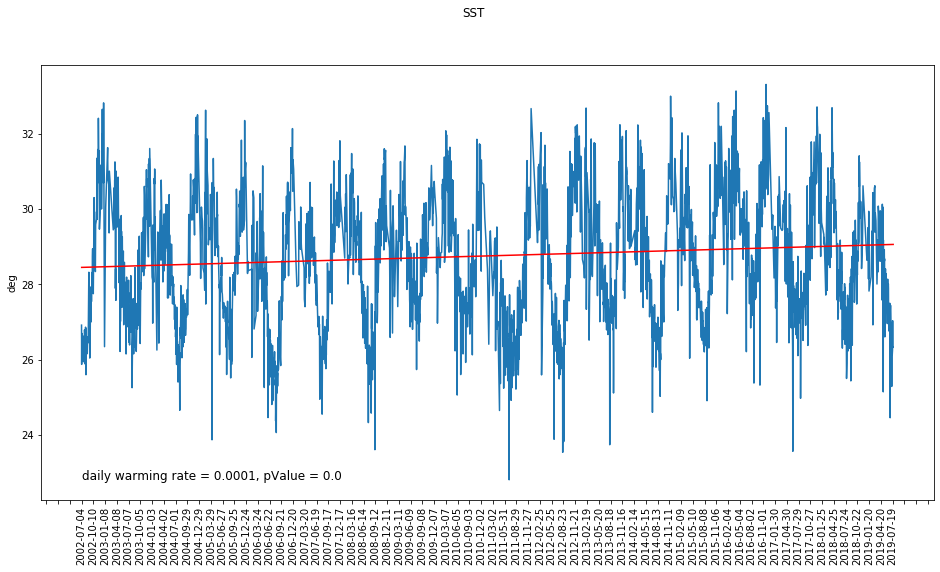

In [23]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,sstDF['meanI'].size+1,1)
sstDF['ind'] = ind

meanFit = sm.ols(formula='meanI ~ ind', data=sstDF).fit()
print(meanFit.summary())

predict = meanFit.predict(sstDF)
sstDF['mean_fitted'] = predict

#rate = (sstDF['mean_fitted'].max() - sstDF['mean_fitted'].min()) / sstDF['mean_fitted'].size
rate = round(meanFit.params[1],4)
pValue = round(meanFit.pvalues[1],4)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = sstDF.index[0]
textY = sstDF['meanI'].min()
plt.text(textX,textY,"daily warming rate = " + str(rate) + ", pValue = " + str(pValue),fontsize=12) 
ax.plot(sstDF.index.values,sstDF['meanI'].values)

ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(sstDF.ind, sstDF.mean_fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

                            OLS Regression Results                            
Dep. Variable:                   minI   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     47.22
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           6.96e-12
Time:                        09:26:56   Log-Likelihood:                -11910.
No. Observations:                6214   AIC:                         2.382e+04
Df Residuals:                    6212   BIC:                         2.384e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.7769      0.042    665.350      0.0

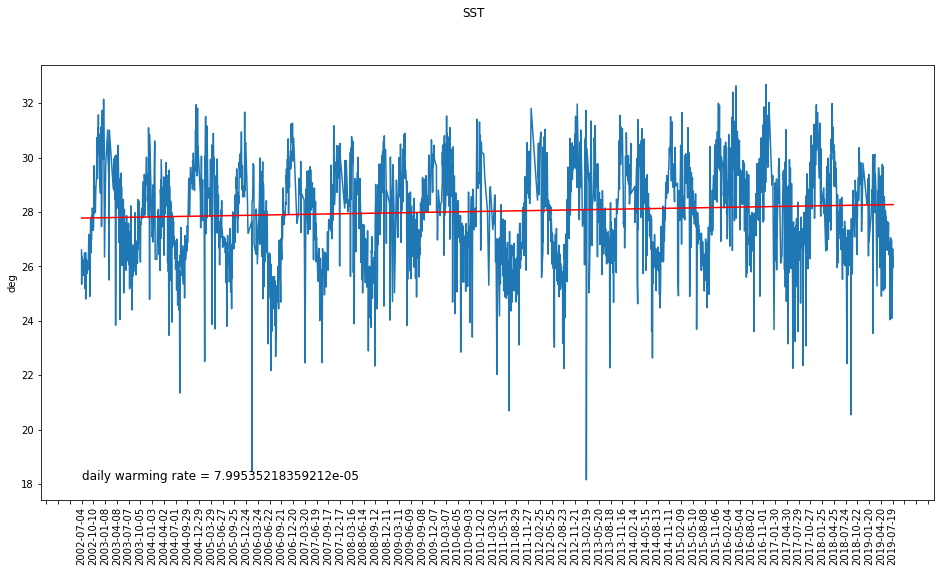

In [22]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm


minFit = sm.ols(formula='minI ~ ind', data=sstDF).fit()
print(minFit.summary())

predict = minFit.predict(sstDF)
sstDF['min_fitted'] = predict

rate = minFit.params[1]

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = sstDF.index[0]
textY = sstDF['minI'].min()
plt.text(textX,textY,"daily warming rate = " + str(rate),fontsize=12)
ax.plot(sstDF.index.values,sstDF['minI'].values)

ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(sstDF.ind, sstDF.min_fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

                            OLS Regression Results                            
Dep. Variable:                   maxI   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     82.67
Date:                Mon, 20 Jan 2020   Prob (F-statistic):           1.28e-19
Time:                        09:27:17   Log-Likelihood:                -11864.
No. Observations:                6214   AIC:                         2.373e+04
Df Residuals:                    6212   BIC:                         2.375e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.0049      0.041    699.954      0.0

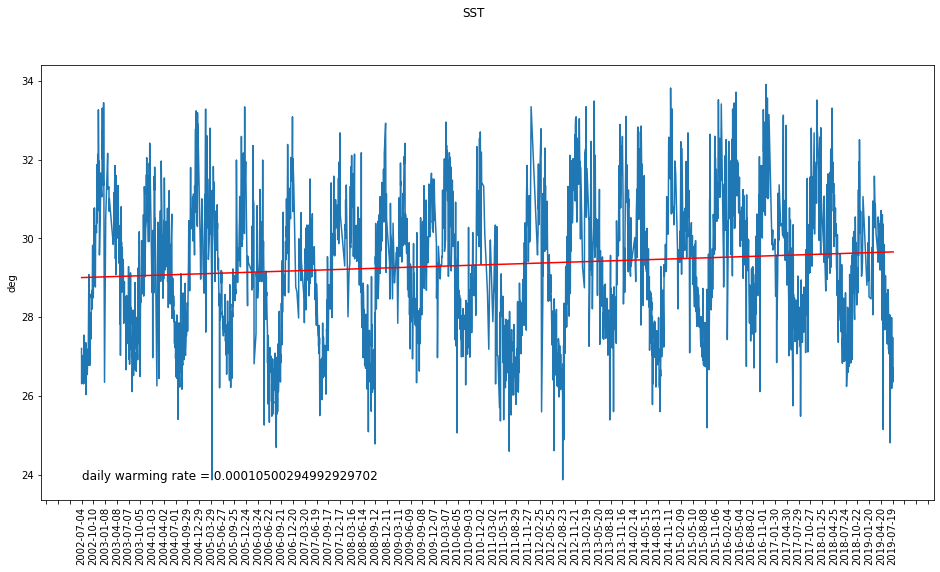

In [23]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm


maxFit = sm.ols(formula='maxI ~ ind', data=sstDF).fit()
print(maxFit.summary())

predict = maxFit.predict(sstDF)
sstDF['max_fitted'] = predict

rate = maxFit.params[1]

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = sstDF.index[0]
textY = sstDF['maxI'].min()
plt.text(textX,textY,"daily warming rate = " + str(rate),fontsize=12)
ax.plot(sstDF.index.values,sstDF['maxI'].values)

ax.xaxis.set_major_locator(ticker.MultipleLocator(90))
ax.plot(sstDF.ind, sstDF.max_fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

In [24]:
meanFit.params

Intercept    28.451864
ind           0.000098
dtype: float64

**conduct T test and F test on the linear trend (e.g., the ind param in this case)**

In [25]:
t_test = meanFit.t_test("ind = 0")
print(t_test)
f_test = meanFit.f_test("ind = 0")
print(f_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0           9.82e-05   1.12e-05      8.765      0.000    7.62e-05       0.000
<F test: F=array([[76.8236971]]), p=2.380249273545767e-18, df_denom=6.21e+03, df_num=1>


In [30]:
sstDF.head(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range,meanI,minI,maxI,ind,mean_fitted,year
date,,,,,,,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,100,26.605000,27.205000,26.917400,2691.740019,0.145534,26.910000,0.600000,26.917400,26.605000,27.205000,1,28.451962,2002
2002-07-05,Cartier Island,North-west,172.374499,92,25.344999,26.309999,25.874619,2380.464993,0.203260,25.850000,0.965000,25.874619,25.344999,26.309999,2,28.452060,2002
2002-07-06,Cartier Island,North-west,172.374499,96,26.379999,27.030001,26.698750,2563.080006,0.139280,26.702500,0.650002,26.698750,26.379999,27.030001,3,28.452158,2002
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.503724,26.137500,26.860001,4,28.452257,2002
2002-07-08,Cartier Island,North-west,172.374499,96,25.895000,26.690001,26.308698,2525.635004,0.149365,26.297501,0.795000,26.308698,25.895000,26.690001,5,28.452355,2002
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.331339,25.910000,26.707500,6,28.452453,2002
2002-07-10,Cartier Island,North-west,172.374499,98,25.924999,26.725000,26.353980,2582.690004,0.158531,26.365000,0.800001,26.353980,25.924999,26.725000,7,28.452551,2002
2002-07-11,Cartier Island,North-west,172.374499,98,25.985001,26.809999,26.338520,2581.174997,0.178426,26.290001,0.824999,26.338520,25.985001,26.809999,8,28.452649,2002
2002-07-12,Cartier Island,North-west,172.374499,99,25.934999,26.555000,26.243182,2598.075005,0.161215,26.245001,0.620001,26.243182,25.934999,26.555000,9,28.452748,2002


**calculate the daily warming rate. The fit.params[1] is more accurate one**

In [29]:
warming_rate = (sstDF['mean_fitted'].max() - sstDF['mean_fitted'].min()) / sstDF['mean_fitted'].size
print(warming_rate)
print(meanFit.params[1])

9.818887382116777e-05
9.820467759934572e-05


**calculate the warming (deg) in the entire time-series**

In [30]:
# how much warming during last 16 years
sstDF['mean_fitted'].max() - sstDF['mean_fitted'].min()

0.6101456619247365

**add year column**

In [74]:
yearList = []
for date in sstDF.index:
    year = date[:4]
    yearList.append(year)
sstDF['year'] = yearList

**add month, season and yearmonth columns**

In [78]:
monthList = []
seasonList = []
yearmonthList = []
for date in sstDF.index:
    year = date[:4]
    month = date[5:7]
    if month in ['12','01','02']:
        season = 'summer'
    elif month in ['03','04','05']:
        season = 'autumn'
    elif month in ['06','07','08']:
        season = 'winter'
    else:
        season = 'spring'
    monthList.append(month)
    seasonList.append(season)
    yearmonth = year+month
    yearmonthList.append(yearmonth)
sstDF['month'] = monthList
sstDF['season'] = seasonList
sstDF['yearmonth'] = yearmonthList

In [79]:
sstDF.head(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range,meanI,minI,maxI,ind,mean_fitted,year,month,season,yearmonth
date,,,,,,,,,,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,100,26.605000,27.205000,26.917400,2691.740019,0.145534,26.910000,0.600000,26.917400,26.605000,27.205000,1,28.451962,2002,07,winter,200207
2002-07-05,Cartier Island,North-west,172.374499,92,25.344999,26.309999,25.874619,2380.464993,0.203260,25.850000,0.965000,25.874619,25.344999,26.309999,2,28.452060,2002,07,winter,200207
2002-07-06,Cartier Island,North-west,172.374499,96,26.379999,27.030001,26.698750,2563.080006,0.139280,26.702500,0.650002,26.698750,26.379999,27.030001,3,28.452158,2002,07,winter,200207
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.503724,26.137500,26.860001,4,28.452257,2002,07,winter,200207
2002-07-08,Cartier Island,North-west,172.374499,96,25.895000,26.690001,26.308698,2525.635004,0.149365,26.297501,0.795000,26.308698,25.895000,26.690001,5,28.452355,2002,07,winter,200207
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.331339,25.910000,26.707500,6,28.452453,2002,07,winter,200207
2002-07-10,Cartier Island,North-west,172.374499,98,25.924999,26.725000,26.353980,2582.690004,0.158531,26.365000,0.800001,26.353980,25.924999,26.725000,7,28.452551,2002,07,winter,200207
2002-07-11,Cartier Island,North-west,172.374499,98,25.985001,26.809999,26.338520,2581.174997,0.178426,26.290001,0.824999,26.338520,25.985001,26.809999,8,28.452649,2002,07,winter,200207
2002-07-12,Cartier Island,North-west,172.374499,99,25.934999,26.555000,26.243182,2598.075005,0.161215,26.245001,0.620001,26.243182,25.934999,26.555000,9,28.452748,2002,07,winter,200207


**group by year**

In [31]:
x = sstDF['mean'].groupby(sstDF['year'])
yearmeanSSTDF = x.describe()
x = sstDF['min'].groupby(sstDF['year'])
yearminSSTDF = x.describe()
x = sstDF['max'].groupby(sstDF['year'])
yearmaxSSTDF = x.describe()
x = sstDF['std'].groupby(sstDF['year'])
yearstdSSTDF = x.describe()


**group by yearmonth**

In [80]:
x = sstDF['mean'].groupby(sstDF['yearmonth'])
yearmonthmeanSSTDF = x.describe()

x = sstDF['std'].groupby(sstDF['yearmonth'])
yearmonthstdSSTDF = x.describe()

**the describe function generates a dataframe with the groupping results, and in this case, the time-series of annual statistics (e.g., mean, std, etc)**

In [29]:
yearmeanSSTDF

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2002,95.0,28.098472,2.062291,25.599245,26.451436,27.002551,29.832189,32.823315
2003,184.0,28.406648,1.461423,25.254770,27.114279,28.233588,29.567336,31.633979
2004,181.0,28.246688,1.544397,24.654663,26.837600,28.058500,29.469737,32.506290
2005,186.0,28.654824,1.547309,23.870001,27.392712,28.601389,29.845872,32.628804
2006,166.0,27.699148,1.855979,24.062323,26.034163,27.606199,29.119345,32.140765
2007,170.0,28.206630,1.492871,24.551968,26.823654,28.486718,29.294046,31.816250
2008,183.0,28.276965,1.630590,23.607656,26.883722,28.586313,29.529410,31.605294
2009,175.0,28.776871,1.207242,25.736389,27.693211,28.818698,29.743796,31.679343
2010,163.0,28.807331,1.514837,25.059999,27.583078,28.654080,29.862322,32.081316


In [32]:
yearstdSSTDF

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2002,95.0,0.240114,0.127427,0.0,0.162063,0.201402,0.296701,0.834038
2003,184.0,0.273703,0.238173,0.0,0.164169,0.206287,0.291903,1.676003
2004,181.0,0.278051,0.189623,0.0,0.180067,0.219134,0.308560,1.362961
2005,186.0,0.278207,0.189348,0.0,0.178994,0.222138,0.328794,1.594161
2006,166.0,0.285900,0.237140,0.0,0.168112,0.220783,0.308220,2.326843
2007,170.0,0.260282,0.190221,0.0,0.169863,0.214523,0.287042,1.889011
2008,183.0,0.289119,0.240019,0.0,0.168630,0.219428,0.311908,1.791554
2009,175.0,0.276504,0.216405,0.0,0.181535,0.211661,0.292084,1.639992
2010,163.0,0.301908,0.238580,0.0,0.179760,0.234281,0.315544,1.514243


**year 2002 and 2019 are partial years and thus should be excluded**

In [95]:
yearmeanSSTDF1 = yearmeanSSTDF.loc['2003':'2018']
yearminSSTDF1 = yearminSSTDF.loc['2003':'2018']
yearmaxSSTDF1 = yearmaxSSTDF.loc['2003':'2018']
yearstdSSTDF1 = yearstdSSTDF.loc['2003':'2018']

yearmonthmeanSSTDF1 = yearmonthmeanSSTDF.loc['200301':'201812']
yearmonthstdSSTDF1 = yearmonthstdSSTDF.loc['200301':'201812']

In [81]:
yearmonthmeanSSTDF

,count,mean,std,min,25%,50%,75%,max
yearmonth,,,,,,,,
200207,20.0,26.394721,0.278965,25.874619,26.236961,26.351914,26.623125,26.917400
200208,19.0,26.392725,0.295006,25.599245,26.297019,26.451188,26.545188,26.863627
200209,18.0,27.128438,0.656572,26.042728,26.696919,27.025819,27.814452,28.322526
200210,13.0,28.757265,0.769734,27.753145,28.340610,28.577400,28.946333,30.306465
200211,12.0,30.911777,0.892828,29.468000,30.436866,31.119798,31.501562,32.414570
200212,13.0,31.300076,0.884475,30.003830,30.695000,31.206428,31.795385,32.823315
200301,5.0,29.987862,2.129164,26.344999,29.953541,30.791951,31.214839,31.633979
200302,3.0,30.333491,0.858610,29.367572,29.995236,30.622900,30.816450,31.010000
200303,13.0,29.826879,0.931467,27.895000,29.482531,29.803542,30.537677,31.254588


In [82]:
yearmonthstdSSTDF

,count,mean,std,min,25%,50%,75%,max
yearmonth,,,,,,,,
200207,20.0,0.157923,0.026314,0.119076,0.138340,0.153948,0.180464,0.203260
200208,19.0,0.208815,0.082624,0.133034,0.159710,0.181660,0.222764,0.481621
200209,18.0,0.268558,0.127905,0.125000,0.191238,0.235810,0.288470,0.651991
200210,13.0,0.257405,0.084731,0.164803,0.201402,0.223344,0.301895,0.419171
200211,12.0,0.265400,0.124545,0.000000,0.195960,0.298612,0.348473,0.430816
200212,13.0,0.332294,0.217008,0.000000,0.194719,0.343959,0.368467,0.834038
200301,5.0,0.224655,0.134627,0.000000,0.233437,0.262708,0.265127,0.362003
200302,3.0,0.572391,0.655117,0.000000,0.215135,0.430271,0.858586,1.286902
200303,13.0,0.415587,0.430302,0.079726,0.200096,0.253514,0.359093,1.676003


**plot the time-series of the annual mean, min and max**

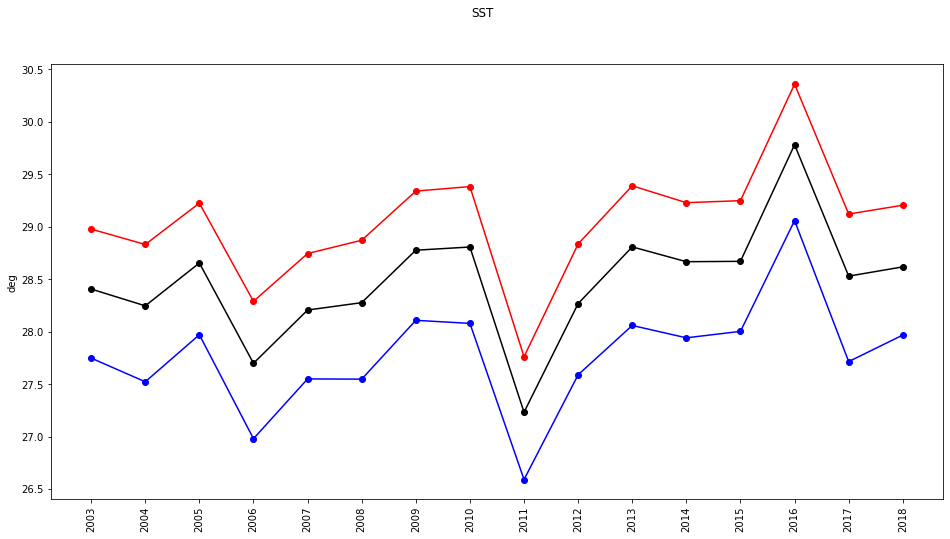

In [28]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,marker='o',color='black')
ax.plot(yearminSSTDF1.index.values,yearminSSTDF1['mean'].values,marker='o',color='blue')
ax.plot(yearmaxSSTDF1.index.values,yearmaxSSTDF1['mean'].values,marker='o',color='red')

ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**plot the annual mean SST time-series and the (temporal) standard deviation**

In [135]:
yearmeanSSTDF1

,count,mean,std,min,25%,50%,75%,max,ind,fitted
year,,,,,,,,,,
2003,184.0,28.406648,1.461423,25.254770,27.114279,28.233588,29.567336,31.633979,1,28.138827
2004,181.0,28.246688,1.544397,24.654663,26.837600,28.058500,29.469737,32.506290,2,28.184087
2005,186.0,28.654824,1.547309,23.870001,27.392712,28.601389,29.845872,32.628804,3,28.229347
2006,166.0,27.699148,1.855979,24.062323,26.034163,27.606199,29.119345,32.140765,4,28.274607
2007,170.0,28.206630,1.492871,24.551968,26.823654,28.486718,29.294046,31.816250,5,28.319867
2008,183.0,28.276965,1.630590,23.607656,26.883722,28.586313,29.529410,31.605294,6,28.365127
2009,175.0,28.776871,1.207242,25.736389,27.693211,28.818698,29.743796,31.679343,7,28.410387
2010,163.0,28.807331,1.514837,25.059999,27.583078,28.654080,29.862322,32.081316,8,28.455647
2011,154.0,27.232738,1.425271,22.807916,26.207630,27.022184,27.952774,32.671705,9,28.500907


In [1]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

ax.plot(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,marker='o',color='red')
ax.plot(yearstdSSTDF1.index.values,yearmeanSSTDF1['mean'].values-yearmeanSSTDF1['std'],marker='o',color='blue')
ax.plot(yearstdSSTDF1.index.values,yearmeanSSTDF1['mean'].values+yearmeanSSTDF1['std'],marker='o',color='blue')

ax.set_ylabel('deg')
fig.suptitle('mean SST (red) +- std (blue)')

plt.show()

NameError: name 'plt' is not defined

In [72]:
sstDF1 = sstDF.loc['2003-01-01':'2018-12-31']

In [73]:
sstDF1.tail(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range,meanI,minI,maxI,ind,mean_fitted,year,month,season
date,,,,,,,,,,,,,,,,,,,
2018-12-22,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.433167,28.898000,29.712000,6002,29.041288,2018,12,summer
2018-12-23,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.367278,28.848166,29.636833,6003,29.041386,2018,12,summer
2018-12-24,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.301389,28.798333,29.561666,6004,29.041485,2018,12,summer
2018-12-25,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.235500,28.748499,29.486500,6005,29.041583,2018,12,summer
2018-12-26,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.169611,28.698666,29.411333,6006,29.041681,2018,12,summer
2018-12-27,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.103722,28.648833,29.336166,6007,29.041779,2018,12,summer
2018-12-28,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29.037833,28.598999,29.261000,6008,29.041877,2018,12,summer
2018-12-29,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.971944,28.549166,29.185833,6009,29.041976,2018,12,summer
2018-12-30,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.906055,28.499333,29.110666,6010,29.042074,2018,12,summer


**plot daily SST time-series and the annual mean SST time-series**

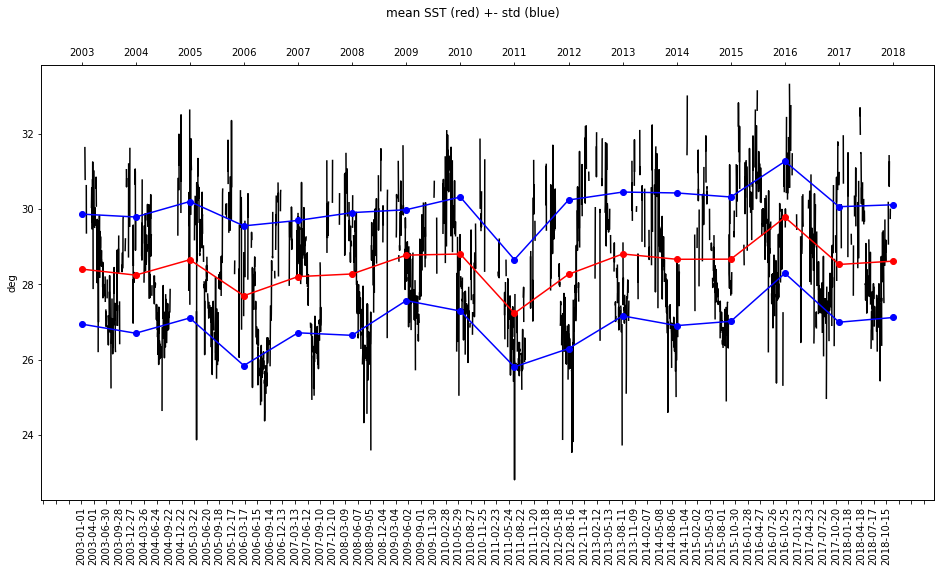

In [137]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(sstDF1.index.values,sstDF1['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(90))

ax2 = ax1.twiny()
ax2.plot(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,marker='o',color='red')
ax2.plot(yearstdSSTDF1.index.values,yearmeanSSTDF1['mean'].values-yearmeanSSTDF1['std'],marker='o',color='blue')
ax2.plot(yearstdSSTDF1.index.values,yearmeanSSTDF1['mean'].values+yearmeanSSTDF1['std'],marker='o',color='blue')



#ax1.set_xticks(yearmeanSSTDF1.index.values)
ax1.set_ylabel('deg')
fig.suptitle('mean SST (red) +- std (blue)')



plt.show()

**plot the daily SST time-series and monthly SST time-series**

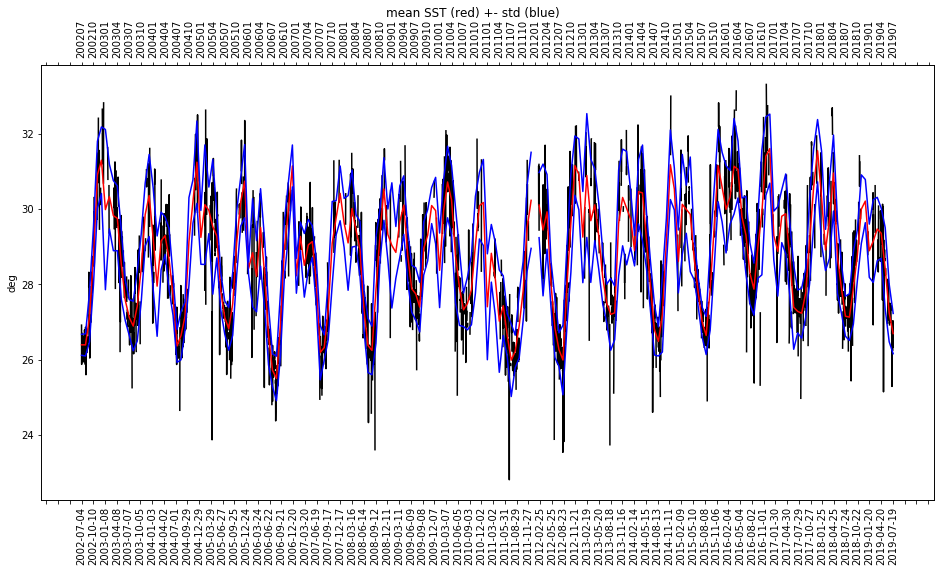

In [138]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(sstDF.index.values,sstDF['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(90))

ax2 = ax1.twiny()
ax2.plot(yearmonthmeanSSTDF.index.values,yearmonthmeanSSTDF['mean'].values,color='red')
ax2.plot(yearmonthstdSSTDF.index.values,yearmonthmeanSSTDF['mean'].values-yearmonthmeanSSTDF['std'],color='blue')
ax2.plot(yearmonthstdSSTDF.index.values,yearmonthmeanSSTDF['mean'].values+yearmonthmeanSSTDF['std'],color='blue')
#ax2.set_xticklabels(yearmonthmeanSSTDF.index.values,rotation="vertical")
plt.xticks(rotation='vertical')
ax2.xaxis.set_major_locator(ticker.MultipleLocator(3))

#ax1.set_xticks(yearmeanSSTDF1.index.values)
ax1.set_ylabel('deg')
fig.suptitle('mean SST (red) +- std (blue)')



plt.show()

**plot monthly SST time-series and annual SST time-series**

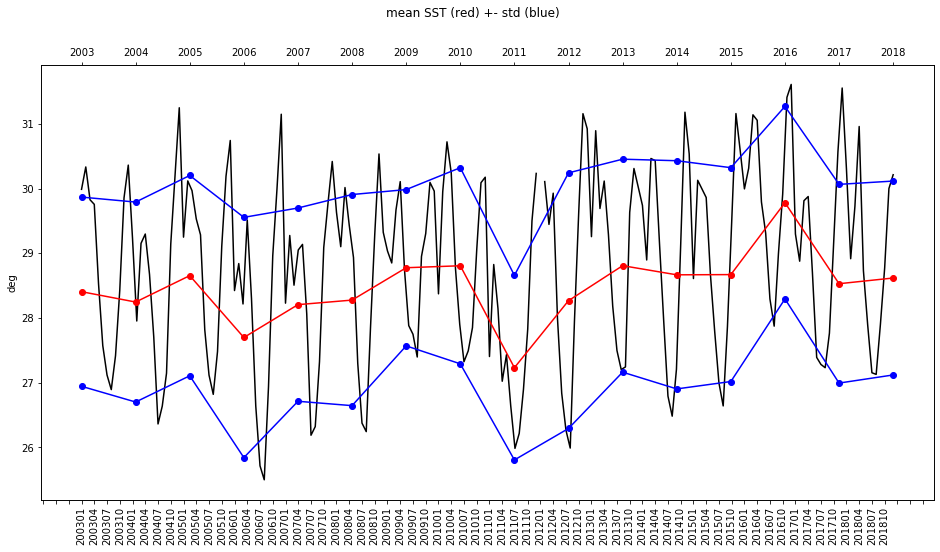

In [139]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(yearmonthmeanSSTDF1.index.values,yearmonthmeanSSTDF1['mean'].values,color='black')
ax1.xaxis.set_major_locator(ticker.MultipleLocator(3))

ax2 = ax1.twiny()
ax2.plot(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,marker='o',color='red')
ax2.plot(yearstdSSTDF1.index.values,yearmeanSSTDF1['mean'].values-yearmeanSSTDF1['std'],marker='o',color='blue')
ax2.plot(yearstdSSTDF1.index.values,yearmeanSSTDF1['mean'].values+yearmeanSSTDF1['std'],marker='o',color='blue')

ax1.set_ylabel('deg')
fig.suptitle('mean SST (red) +- std (blue)')



plt.show()

**plot and fit the time-series of annual mean, min and max**

In [97]:
yearmeanSSTDF1

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2003,184.0,28.406648,1.461423,25.254770,27.114279,28.233588,29.567336,31.633979
2004,181.0,28.246688,1.544397,24.654663,26.837600,28.058500,29.469737,32.506290
2005,186.0,28.654824,1.547309,23.870001,27.392712,28.601389,29.845872,32.628804
2006,166.0,27.699148,1.855979,24.062323,26.034163,27.606199,29.119345,32.140765
2007,170.0,28.206630,1.492871,24.551968,26.823654,28.486718,29.294046,31.816250
2008,183.0,28.276965,1.630590,23.607656,26.883722,28.586313,29.529410,31.605294
2009,175.0,28.776871,1.207242,25.736389,27.693211,28.818698,29.743796,31.679343
2010,163.0,28.807331,1.514837,25.059999,27.583078,28.654080,29.862322,32.081316
2011,154.0,27.232738,1.425271,22.807916,26.207630,27.022184,27.952774,32.671705


In [98]:
yearstdSSTDF1

,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2003,184.0,0.273703,0.238173,0.0,0.164169,0.206287,0.291903,1.676003
2004,181.0,0.278051,0.189623,0.0,0.180067,0.219134,0.308560,1.362961
2005,186.0,0.278207,0.189348,0.0,0.178994,0.222138,0.328794,1.594161
2006,166.0,0.285900,0.237140,0.0,0.168112,0.220783,0.308220,2.326843
2007,170.0,0.260282,0.190221,0.0,0.169863,0.214523,0.287042,1.889011
2008,183.0,0.289119,0.240019,0.0,0.168630,0.219428,0.311908,1.791554
2009,175.0,0.276504,0.216405,0.0,0.181535,0.211661,0.292084,1.639992
2010,163.0,0.301908,0.238580,0.0,0.179760,0.234281,0.315544,1.514243
2011,154.0,0.263253,0.190786,0.0,0.163047,0.210953,0.287630,1.659805


/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2.558
Date:                Mon, 24 Feb 2020   Prob (F-statistic):              0.132
Time:                        16:00:45   Log-Likelihood:                -11.227
No. Observations:                  16   AIC:                             26.45
Df Residuals:                      14   BIC:                             28.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.0936      0.274    102.672      0.0

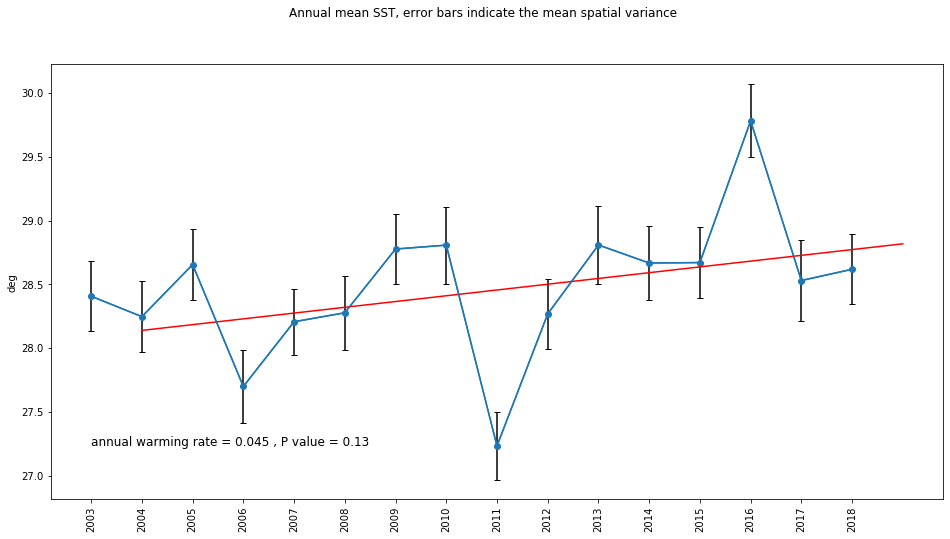

In [113]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanSSTDF1['mean'].size+1,1)
yearmeanSSTDF1['ind'] = ind

yearmeanFit = sm.ols(formula='mean ~ ind', data=yearmeanSSTDF1).fit()
print(yearmeanFit.summary())

predict = yearmeanFit.predict(yearmeanSSTDF1)
yearmeanSSTDF1['fitted'] = predict

rate = round(yearmeanFit.params[1],3)
pValue = round(yearmeanFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanSSTDF1.index[0]
textY = yearmeanSSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,marker='o')

ax.errorbar(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,yerr=yearstdSSTDF1['mean'].values,ecolor="black",
           capsize=3.0)

ax.plot(yearmeanSSTDF1.ind, yearmeanSSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('Annual mean SST, error bars indicate the mean spatial variance')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2.558
Date:                Mon, 24 Feb 2020   Prob (F-statistic):              0.132
Time:                        16:01:53   Log-Likelihood:                -11.227
No. Observations:                  16   AIC:                             26.45
Df Residuals:                      14   BIC:                             28.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.0936      0.274    102.672      0.0

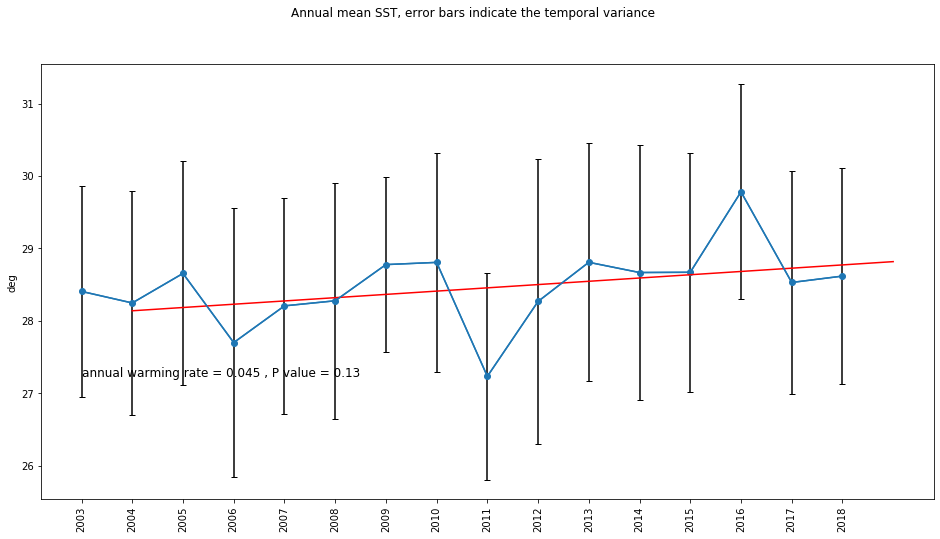

In [114]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanSSTDF1['mean'].size+1,1)
yearmeanSSTDF1['ind'] = ind

yearmeanFit = sm.ols(formula='mean ~ ind', data=yearmeanSSTDF1).fit()
print(yearmeanFit.summary())

predict = yearmeanFit.predict(yearmeanSSTDF1)
yearmeanSSTDF1['fitted'] = predict

rate = round(yearmeanFit.params[1],3)
pValue = round(yearmeanFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanSSTDF1.index[0]
textY = yearmeanSSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,marker='o')
ax.errorbar(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,yerr=yearmeanSSTDF1['std'].values,ecolor="black",
           capsize=3.0)

ax.plot(yearmeanSSTDF1.ind, yearmeanSSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('Annual mean SST, error bars indicate the temporal variance')

plt.show()

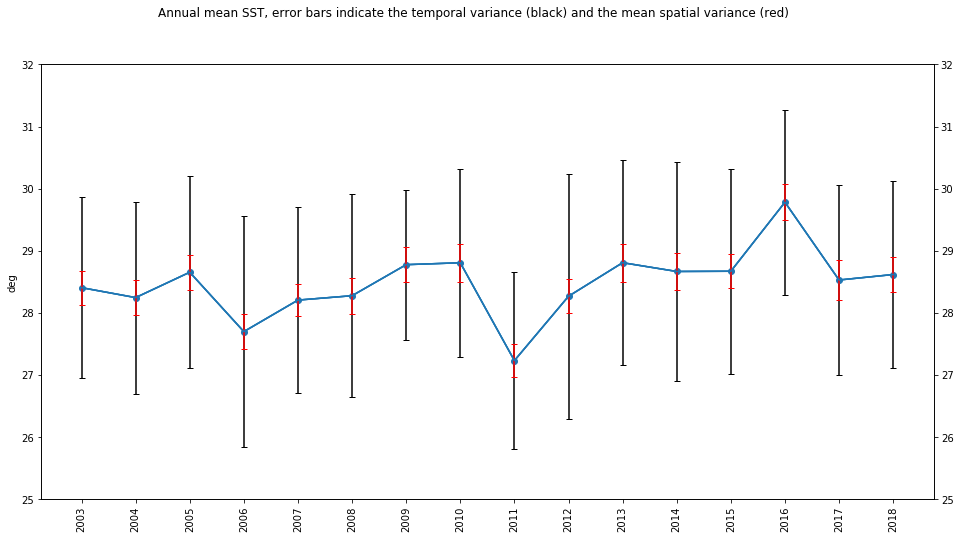

In [120]:
import matplotlib.ticker as ticker

fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')


ax1.plot(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,marker='o')
ax1.errorbar(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,yerr=yearmeanSSTDF1['std'].values,ecolor="black",
           capsize=3.0)

ax1.set_ylabel('deg')
ax1.set_ylim(ymin=25,ymax=32)
ax2 = ax1.twinx()
ax2.errorbar(yearmeanSSTDF1.index.values,yearmeanSSTDF1['mean'].values,yerr=yearstdSSTDF1['mean'].values,ecolor="red",
           capsize=3.0)
ax2.set_ylim(ymin=25,ymax=32)
fig.suptitle('Annual mean SST, error bars indicate the temporal variance (black) and the mean spatial variance (red)')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.145
Model:                            OLS   Adj. R-squared:                  0.084
Method:                 Least Squares   F-statistic:                     2.376
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.145
Time:                        09:30:08   Log-Likelihood:                -10.985
No. Observations:                  16   AIC:                             25.97
Df Residuals:                      14   BIC:                             27.52
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.4121      0.270    101.705      0.0

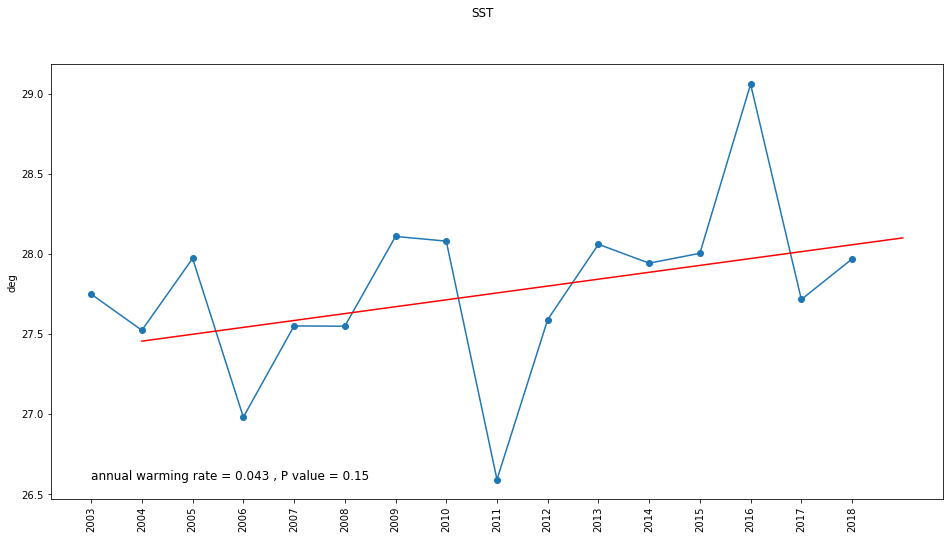

In [37]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearminSSTDF1['mean'].size+1,1)
yearminSSTDF1['ind'] = ind

yearminFit = sm.ols(formula='mean ~ ind', data=yearminSSTDF1).fit()
print(yearminFit.summary())

predict = yearminFit.predict(yearminSSTDF1)
yearminSSTDF1['fitted'] = predict

rate = round(yearminFit.params[1],3)
pValue = round(yearminFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearminSSTDF1.index[0]
textY = yearminSSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearminSSTDF1.index.values,yearminSSTDF1['mean'].values,marker='o')


ax.plot(yearminSSTDF1.ind, yearminSSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2.558
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.132
Time:                        09:30:12   Log-Likelihood:                -11.421
No. Observations:                  16   AIC:                             26.84
Df Residuals:                      14   BIC:                             28.39
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.6618      0.277    103.482      0.0

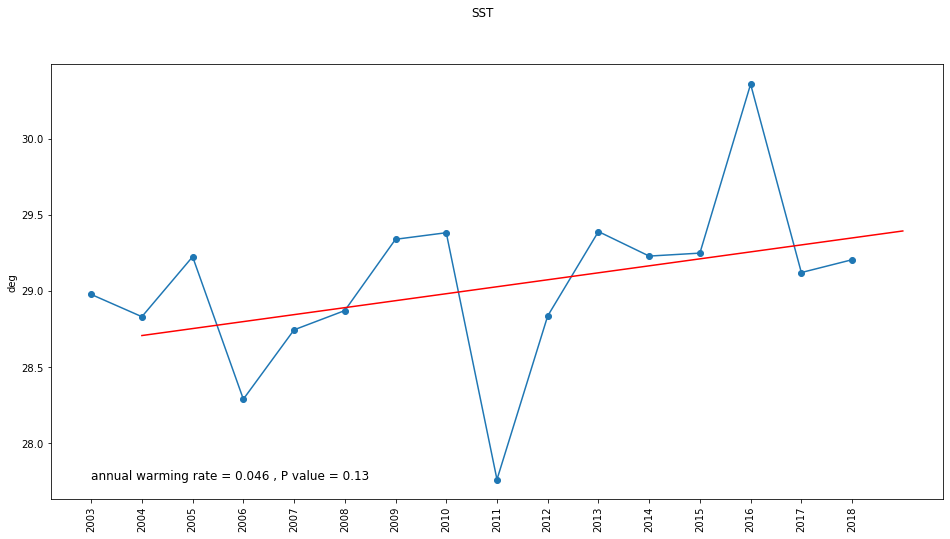

In [38]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmaxSSTDF1['mean'].size+1,1)
yearmaxSSTDF1['ind'] = ind

yearmaxFit = sm.ols(formula='mean ~ ind', data=yearmaxSSTDF1).fit()
print(yearmaxFit.summary())

predict = yearmaxFit.predict(yearmaxSSTDF1)
yearmaxSSTDF1['fitted'] = predict

rate = round(yearmaxFit.params[1],3)
pValue = round(yearmaxFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmaxSSTDF1.index[0]
textY = yearmaxSSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmaxSSTDF1.index.values,yearmaxSSTDF1['mean'].values,marker='o')


ax.plot(yearmaxSSTDF1.ind, yearmaxSSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**the T test and F test both indicate that the trend is not statistically significant for the time-series of annual mean**

In [39]:
t_test = yearmeanFit.t_test("ind = 0")
print(t_test)
f_test = yearmeanFit.f_test("ind = 0")
print(f_test)

                             Test for Constraints                             
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
c0             0.0453      0.028      1.599      0.132      -0.015       0.106
<F test: F=array([[2.55819809]]), p=0.1320410226091562, df_denom=14, df_num=1>


In [40]:
yearmaxFit.pvalues

Intercept    1.355799e-21
ind          1.320800e-01
dtype: float64

**same analysis based on the interpolated SST time-series**

In [26]:
x = sstDF['meanI'].groupby(sstDF['year'])
yearmeanISSTDF = x.describe()
x = sstDF['minI'].groupby(sstDF['year'])
yearminISSTDF = x.describe()
x = sstDF['maxI'].groupby(sstDF['year'])
yearmaxISSTDF = x.describe()


yearmeanISSTDF1 = yearmeanISSTDF.loc['2003':'2018']
yearminISSTDF1 = yearminISSTDF.loc['2003':'2018']
yearmaxISSTDF1 = yearmaxISSTDF.loc['2003':'2018']

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     3.683
Date:                Thu, 13 Feb 2020   Prob (F-statistic):             0.0756
Time:                        09:25:29   Log-Likelihood:                -7.9820
No. Observations:                  16   AIC:                             19.96
Df Residuals:                      14   BIC:                             21.51
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.3967      0.223    127.112      0.0

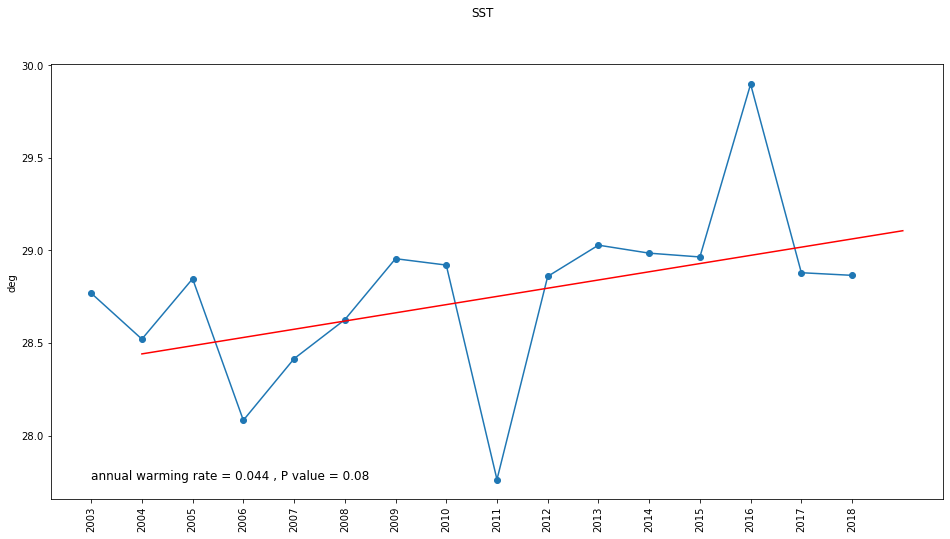

In [28]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmeanISSTDF1['mean'].size+1,1)
yearmeanISSTDF1['ind'] = ind

yearmeanIFit = sm.ols(formula='mean ~ ind', data=yearmeanISSTDF1).fit()
print(yearmeanIFit.summary())

predict = yearmeanIFit.predict(yearmeanISSTDF1)
yearmeanISSTDF1['fitted'] = predict

rate = round(yearmeanIFit.params[1],3)
pValue = round(yearmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmeanISSTDF1.index[0]
textY = yearmeanISSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmeanISSTDF1.index.values,yearmeanISSTDF1['mean'].values,marker='o')


ax.plot(yearmeanISSTDF1.ind, yearmeanISSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.156
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     2.595
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.130
Time:                        09:30:59   Log-Likelihood:                -8.0039
No. Observations:                  16   AIC:                             20.01
Df Residuals:                      14   BIC:                             21.55
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.7203      0.224    123.914      0.0

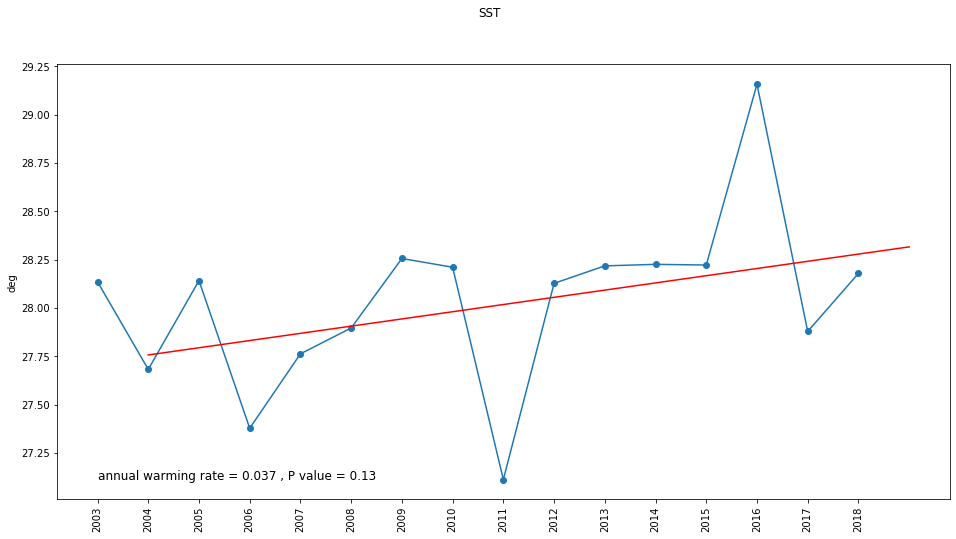

In [44]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearminISSTDF1['mean'].size+1,1)
yearminISSTDF1['ind'] = ind

yearminIFit = sm.ols(formula='mean ~ ind', data=yearminISSTDF1).fit()
print(yearminIFit.summary())

predict = yearminIFit.predict(yearminISSTDF1)
yearminISSTDF1['fitted'] = predict

rate = round(yearminIFit.params[1],3)
pValue = round(yearminIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearminISSTDF1.index[0]
textY = yearminISSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearminISSTDF1.index.values,yearminISSTDF1['mean'].values,marker='o')


ax.plot(yearminISSTDF1.ind, yearminISSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     3.945
Date:                Mon, 20 Jan 2020   Prob (F-statistic):             0.0670
Time:                        09:31:04   Log-Likelihood:                -8.3423
No. Observations:                  16   AIC:                             20.68
Df Residuals:                      14   BIC:                             22.23
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.9516      0.228    126.710      0.0

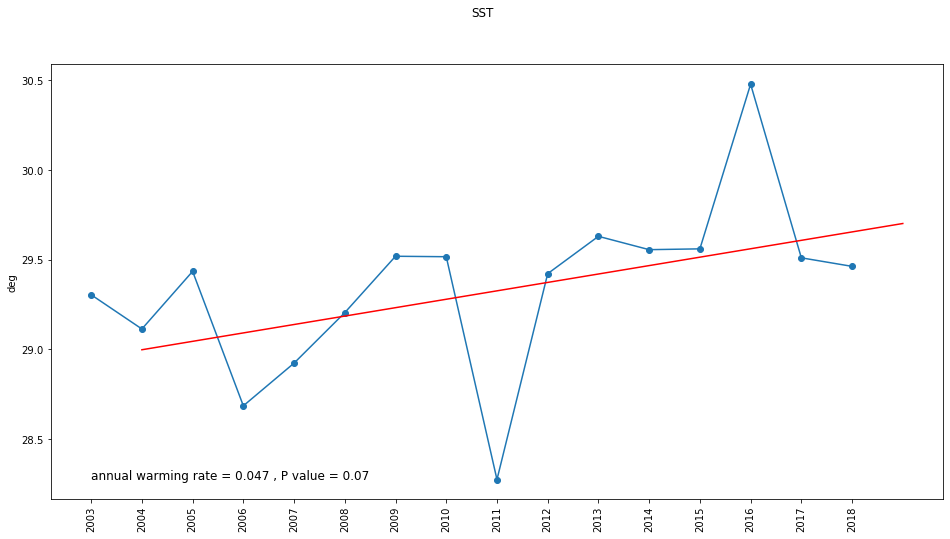

In [45]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,yearmaxISSTDF1['mean'].size+1,1)
yearmaxISSTDF1['ind'] = ind

yearmaxIFit = sm.ols(formula='mean ~ ind', data=yearmaxISSTDF1).fit()
print(yearmaxIFit.summary())

predict = yearmaxIFit.predict(yearmaxISSTDF1)
yearmaxISSTDF1['fitted'] = predict

rate = round(yearmaxIFit.params[1],3)
pValue = round(yearmaxIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = yearmaxISSTDF1.index[0]
textY = yearmaxISSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(yearmaxISSTDF1.index.values,yearmaxISSTDF1['mean'].values,marker='o')


ax.plot(yearmaxISSTDF1.ind, yearmaxISSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

In [121]:
sstDF.head(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range,meanI,minI,maxI,ind,mean_fitted,year,month,season,yearmonth
date,,,,,,,,,,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,100,26.605000,27.205000,26.917400,2691.740019,0.145534,26.910000,0.600000,26.917400,26.605000,27.205000,1,28.451962,2002,07,winter,200207
2002-07-05,Cartier Island,North-west,172.374499,92,25.344999,26.309999,25.874619,2380.464993,0.203260,25.850000,0.965000,25.874619,25.344999,26.309999,2,28.452060,2002,07,winter,200207
2002-07-06,Cartier Island,North-west,172.374499,96,26.379999,27.030001,26.698750,2563.080006,0.139280,26.702500,0.650002,26.698750,26.379999,27.030001,3,28.452158,2002,07,winter,200207
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.503724,26.137500,26.860001,4,28.452257,2002,07,winter,200207
2002-07-08,Cartier Island,North-west,172.374499,96,25.895000,26.690001,26.308698,2525.635004,0.149365,26.297501,0.795000,26.308698,25.895000,26.690001,5,28.452355,2002,07,winter,200207
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.331339,25.910000,26.707500,6,28.452453,2002,07,winter,200207
2002-07-10,Cartier Island,North-west,172.374499,98,25.924999,26.725000,26.353980,2582.690004,0.158531,26.365000,0.800001,26.353980,25.924999,26.725000,7,28.452551,2002,07,winter,200207
2002-07-11,Cartier Island,North-west,172.374499,98,25.985001,26.809999,26.338520,2581.174997,0.178426,26.290001,0.824999,26.338520,25.985001,26.809999,8,28.452649,2002,07,winter,200207
2002-07-12,Cartier Island,North-west,172.374499,99,25.934999,26.555000,26.243182,2598.075005,0.161215,26.245001,0.620001,26.243182,25.934999,26.555000,9,28.452748,2002,07,winter,200207


**monthly statistics**

In [122]:
x = sstDF['meanI'].groupby(sstDF['month'])
monthmeanISSTDF = x.describe()
x = sstDF['mean'].groupby(sstDF['month'])
monthmeanSSTDF = x.describe()
x = sstDF['std'].groupby(sstDF['month'])
monthstdSSTDF = x.describe()


In [128]:
monthmeanISSTDF

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
01,527.0,29.197987,1.045882,26.344999,28.454125,29.106875,29.835491,31.989167
02,480.0,29.332996,1.137974,26.059815,28.613710,29.229923,30.151213,32.686488
03,527.0,29.474656,1.213403,25.594999,28.667986,29.560207,30.304863,32.628500
04,510.0,29.656652,1.302826,23.870001,29.083716,29.740896,30.475422,33.139684
05,527.0,28.727776,0.891829,25.145000,28.183510,28.813036,29.387387,31.082255
06,508.0,27.598839,0.915442,23.565441,27.060919,27.654713,28.068505,30.487941
07,543.0,26.856496,0.835819,22.807916,26.256821,26.931373,27.365008,29.650588
08,520.0,26.712625,0.825243,23.537500,26.205849,26.711779,27.248009,29.446616
09,510.0,27.650091,0.982574,23.607656,27.021411,27.597455,28.230962,31.179545


In [123]:
monthmeanSSTDF

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
01,106.0,29.315788,1.222165,26.344999,28.480019,29.397429,30.158021,31.989167
02,141.0,29.554840,1.264329,26.059815,28.934516,29.430153,30.438000,32.686488
03,196.0,29.796018,1.266548,25.594999,29.024747,29.823949,30.660410,32.628500
04,287.0,29.810783,1.241181,23.870001,29.161630,29.866013,30.602310,33.139684
05,317.0,28.752607,0.944647,25.145000,28.193299,28.859657,29.388030,31.082255
06,339.0,27.628362,0.932836,23.565441,27.084695,27.683774,28.089982,30.487941
07,364.0,26.848166,0.869191,22.807916,26.254232,26.895133,27.366497,29.650588
08,370.0,26.726634,0.853884,23.537500,26.225227,26.713418,27.274967,29.446616
09,319.0,27.661941,1.056208,23.607656,26.981362,27.595263,28.301554,31.179545


In [124]:
monthstdSSTDF

,count,mean,std,min,25%,50%,75%,max
month,,,,,,,,
01,106.0,0.345096,0.279031,0.0,0.184203,0.278033,0.434832,1.639992
02,141.0,0.378695,0.414032,0.0,0.208906,0.263378,0.368472,3.315583
03,196.0,0.385667,0.286147,0.0,0.224367,0.291203,0.473434,1.889011
04,287.0,0.307925,0.238362,0.0,0.184533,0.225628,0.329329,1.695384
05,317.0,0.271897,0.206191,0.0,0.167202,0.202388,0.289111,1.492009
06,339.0,0.235558,0.165292,0.0,0.156079,0.187015,0.256394,1.362961
07,364.0,0.224590,0.158866,0.0,0.152871,0.180546,0.228229,1.659805
08,370.0,0.223671,0.122211,0.0,0.157668,0.190375,0.244618,1.104063
09,319.0,0.279424,0.189377,0.0,0.185888,0.227603,0.309890,1.679002


**plot the monthly mean**

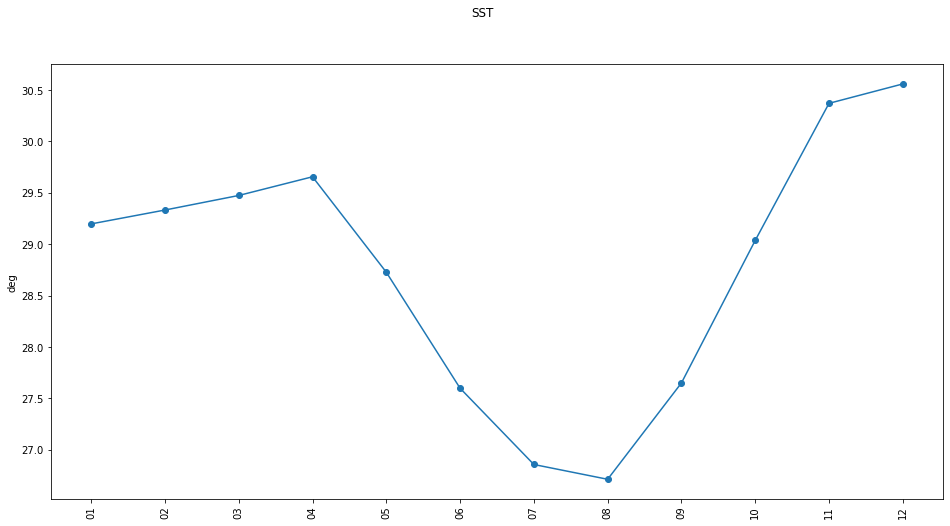

In [31]:
fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
ax.plot(monthmeanISSTDF.index.values,monthmeanISSTDF['mean'].values,marker='o')

ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

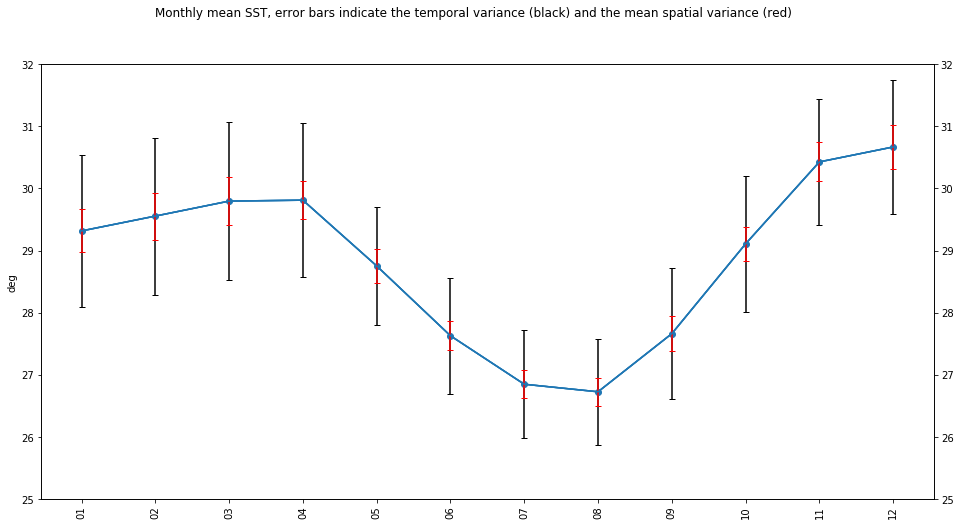

In [140]:
fig, ax1 = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
ax1.plot(monthmeanSSTDF.index.values,monthmeanSSTDF['mean'].values,marker='o')
ax1.errorbar(monthmeanSSTDF.index.values,monthmeanSSTDF['mean'].values,yerr=monthmeanSSTDF['std'].values,ecolor="black",capsize=3.0)
ax1.set_ylabel('deg')
ax1.set_ylim(ymin=25,ymax=32)
ax2 = ax1.twinx()
ax2.errorbar(monthmeanSSTDF.index.values,monthmeanSSTDF['mean'].values,yerr=monthstdSSTDF['mean'].values,ecolor="red",capsize=3.0)
ax2.set_ylim(ymin=25,ymax=32)
fig.suptitle('Monthly mean SST, error bars indicate the temporal variance (black) and the mean spatial variance (red)')

plt.show()

**annual time-series of monthly statistics (mean, std, etc)**

In [32]:
# note how to deal with multiindex
meanIDF = sstDF[['meanI','year','month']]
x = meanIDF.groupby(['year','month'])
yearmonthmeanISSTDF = x.describe()

idx = pd.IndexSlice
JanmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['01']],:]
FebmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['02']],:]
MarmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['03']],:]
AprmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['04']],:]
MaymeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['05']],:]
JunmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['06']],:]
JulmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['07']],:]
AugmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['08']],:]
SepmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['09']],:]
OctmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['10']],:]
NovmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['11']],:]
DecmeanISSTDF = yearmonthmeanISSTDF.loc[idx[:,['12']],:]
JanmeanISSTDF.reset_index(inplace=True)
JanmeanISSTDF.set_index('year',inplace=True)
x = JanmeanISSTDF.columns.droplevel(level=0)
JanmeanISSTDF.columns=x
FebmeanISSTDF.reset_index(inplace=True)
FebmeanISSTDF.set_index('year',inplace=True)
x = FebmeanISSTDF.columns.droplevel(level=0)
FebmeanISSTDF.columns=x
MarmeanISSTDF.reset_index(inplace=True)
MarmeanISSTDF.set_index('year',inplace=True)
x = MarmeanISSTDF.columns.droplevel(level=0)
MarmeanISSTDF.columns=x
AprmeanISSTDF.reset_index(inplace=True)
AprmeanISSTDF.set_index('year',inplace=True)
x = AprmeanISSTDF.columns.droplevel(level=0)
AprmeanISSTDF.columns=x
MaymeanISSTDF.reset_index(inplace=True)
MaymeanISSTDF.set_index('year',inplace=True)
x = MaymeanISSTDF.columns.droplevel(level=0)
MaymeanISSTDF.columns=x
JunmeanISSTDF.reset_index(inplace=True)
JunmeanISSTDF.set_index('year',inplace=True)
x = JunmeanISSTDF.columns.droplevel(level=0)
JunmeanISSTDF.columns=x
JulmeanISSTDF.reset_index(inplace=True)
JulmeanISSTDF.set_index('year',inplace=True)
x = JulmeanISSTDF.columns.droplevel(level=0)
JulmeanISSTDF.columns=x
AugmeanISSTDF.reset_index(inplace=True)
AugmeanISSTDF.set_index('year',inplace=True)
x = AugmeanISSTDF.columns.droplevel(level=0)
AugmeanISSTDF.columns=x
SepmeanISSTDF.reset_index(inplace=True)
SepmeanISSTDF.set_index('year',inplace=True)
x = SepmeanISSTDF.columns.droplevel(level=0)
SepmeanISSTDF.columns=x
OctmeanISSTDF.reset_index(inplace=True)
OctmeanISSTDF.set_index('year',inplace=True)
x = OctmeanISSTDF.columns.droplevel(level=0)
OctmeanISSTDF.columns=x
NovmeanISSTDF.reset_index(inplace=True)
NovmeanISSTDF.set_index('year',inplace=True)
x = NovmeanISSTDF.columns.droplevel(level=0)
NovmeanISSTDF.columns=x
DecmeanISSTDF.reset_index(inplace=True)
DecmeanISSTDF.set_index('year',inplace=True)
x = DecmeanISSTDF.columns.droplevel(level=0)
DecmeanISSTDF.columns=x

In [273]:
FebmeanISSTDF

,,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,,
2003,02,28.0,30.523279,0.344053,29.367572,30.320487,30.633466,30.733840,31.010000
2004,02,29.0,27.822054,0.867531,26.254999,27.147020,27.854039,28.537355,29.392772
2005,02,28.0,29.508720,1.472442,27.477500,28.306813,29.432390,30.462939,32.628804
2006,02,28.0,28.725440,1.367071,26.059815,28.031616,28.783258,29.842652,30.485306
2007,02,28.0,29.125849,0.292399,28.807381,28.935102,29.067885,29.190794,30.057000
2008,02,29.0,29.075287,0.827566,28.010000,28.557129,28.745602,29.575308,30.917000
2009,02,28.0,28.605402,0.516089,27.674167,28.233272,28.593805,29.098293,29.439762
2010,02,28.0,29.717111,0.792487,28.585652,28.974269,29.777191,30.285480,31.385312
2011,02,28.0,28.611913,0.595324,27.341375,28.130772,28.651534,29.152477,29.421357


**plot and fit annual time-series of monthly mean**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/scipy/stats/stats.py:1450: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=17
  "anyway, n=%i" % int(n))
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]

                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                 -0.032
Method:                 Least Squares   F-statistic:                    0.5080
Date:                Thu, 13 Feb 2020   Prob (F-statistic):              0.487
Time:                        09:36:22   Log-Likelihood:                -15.931
No. Observations:                  17   AIC:                             35.86
Df Residuals:                      15   BIC:                             37.53
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.9892      0.334     86.907      0.0

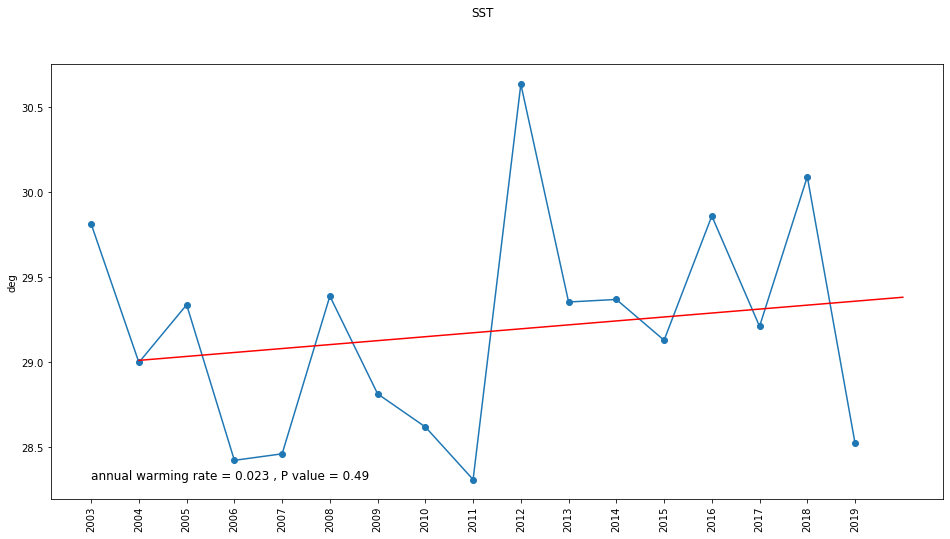

In [33]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,JanmeanISSTDF['mean'].size+1,1)
JanmeanISSTDF['ind'] = ind

JanmeanIFit = sm.ols(formula='mean ~ ind', data=JanmeanISSTDF).fit()
print(JanmeanIFit.summary())

predict = JanmeanIFit.predict(JanmeanISSTDF)
JanmeanISSTDF['fitted'] = predict

rate = round(JanmeanIFit.params[1],3)
pValue = round(JanmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = JanmeanISSTDF.index[0]
textY = JanmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(JanmeanISSTDF.index.values,JanmeanISSTDF['mean'].values,marker='o')


ax.plot(JanmeanISSTDF.ind, JanmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                 -0.053
Method:                 Least Squares   F-statistic:                    0.1905
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.669
Time:                        15:31:57   Log-Likelihood:                -19.338
No. Observations:                  17   AIC:                             42.68
Df Residuals:                      15   BIC:                             44.34
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.1769      0.408     71.582      0.0

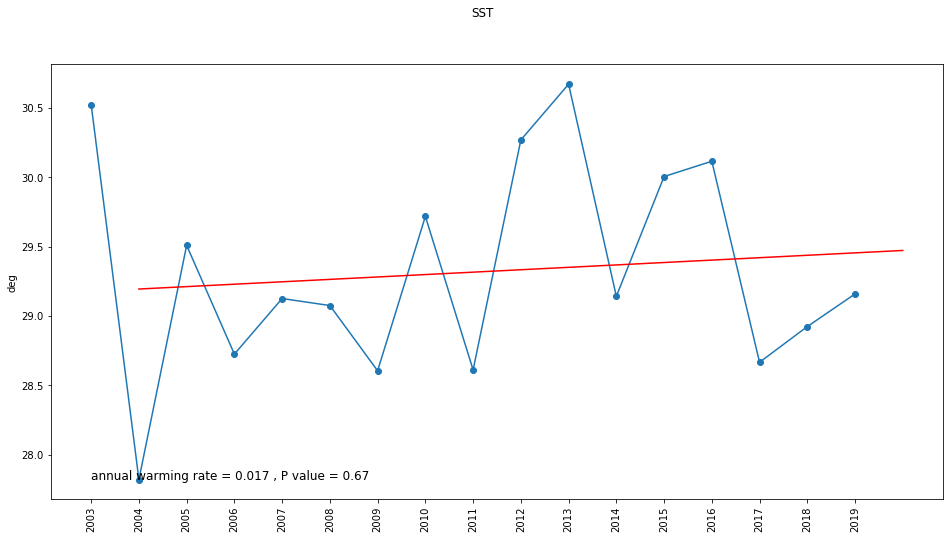

In [275]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,FebmeanISSTDF['mean'].size+1,1)
FebmeanISSTDF['ind'] = ind

FebmeanIFit = sm.ols(formula='mean ~ ind', data=FebmeanISSTDF).fit()
print(FebmeanIFit.summary())

predict = FebmeanIFit.predict(FebmeanISSTDF)
FebmeanISSTDF['fitted'] = predict

rate = round(FebmeanIFit.params[1],3)
pValue = round(FebmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = FebmeanISSTDF.index[0]
textY = FebmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(FebmeanISSTDF.index.values,FebmeanISSTDF['mean'].values,marker='o')


ax.plot(FebmeanISSTDF.ind, FebmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.098
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     1.628
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.221
Time:                        15:31:58   Log-Likelihood:                -19.296
No. Observations:                  17   AIC:                             42.59
Df Residuals:                      15   BIC:                             44.26
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.0190      0.407     71.373      0.0

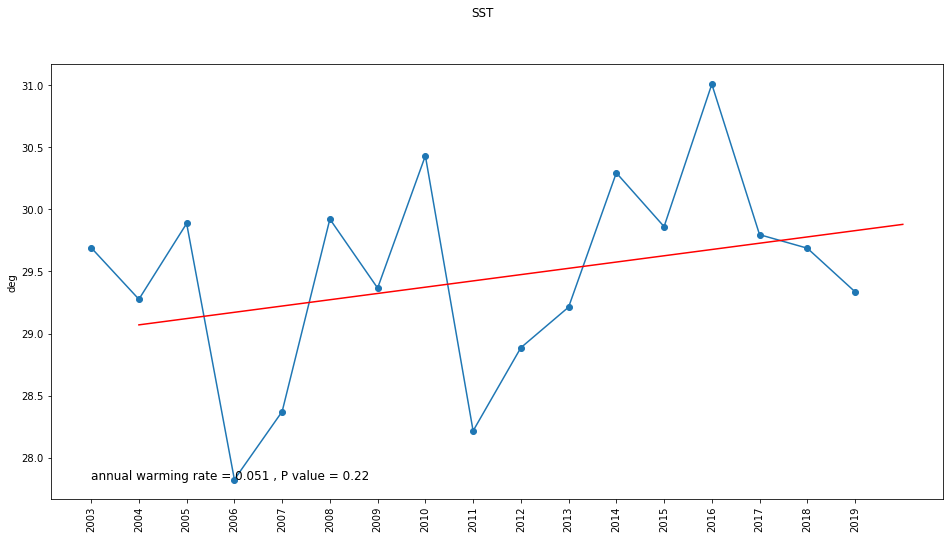

In [276]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,MarmeanISSTDF['mean'].size+1,1)
MarmeanISSTDF['ind'] = ind

MarmeanIFit = sm.ols(formula='mean ~ ind', data=MarmeanISSTDF).fit()
print(MarmeanIFit.summary())

predict = MarmeanIFit.predict(MarmeanISSTDF)
MarmeanISSTDF['fitted'] = predict

rate = round(MarmeanIFit.params[1],3)
pValue = round(MarmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = MarmeanISSTDF.index[0]
textY = MarmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(MarmeanISSTDF.index.values,MarmeanISSTDF['mean'].values,marker='o')


ax.plot(MarmeanISSTDF.ind, MarmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     1.403
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.255
Time:                        15:31:58   Log-Likelihood:                -22.700
No. Observations:                  17   AIC:                             49.40
Df Residuals:                      15   BIC:                             51.07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.1399      0.497     58.664      0.0

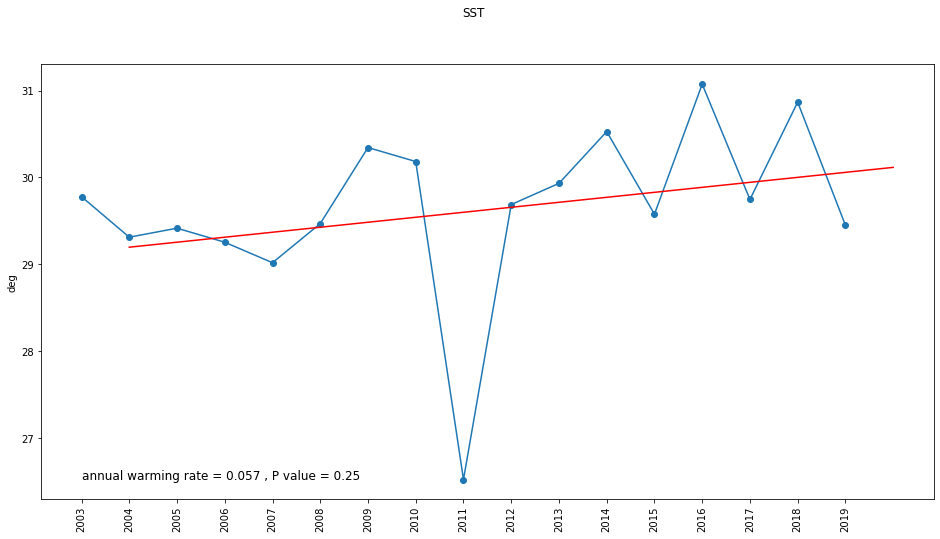

In [277]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,AprmeanISSTDF['mean'].size+1,1)
AprmeanISSTDF['ind'] = ind

AprmeanIFit = sm.ols(formula='mean ~ ind', data=AprmeanISSTDF).fit()
print(AprmeanIFit.summary())

predict = AprmeanIFit.predict(AprmeanISSTDF)
AprmeanISSTDF['fitted'] = predict

rate = round(AprmeanIFit.params[1],3)
pValue = round(AprmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = AprmeanISSTDF.index[0]
textY = AprmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(AprmeanISSTDF.index.values,AprmeanISSTDF['mean'].values,marker='o')


ax.plot(AprmeanISSTDF.ind, AprmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                 -0.059
Method:                 Least Squares   F-statistic:                    0.1073
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.748
Time:                        15:31:58   Log-Likelihood:                -12.535
No. Observations:                  17   AIC:                             29.07
Df Residuals:                      15   BIC:                             30.74
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.6492      0.273    104.879      0.0

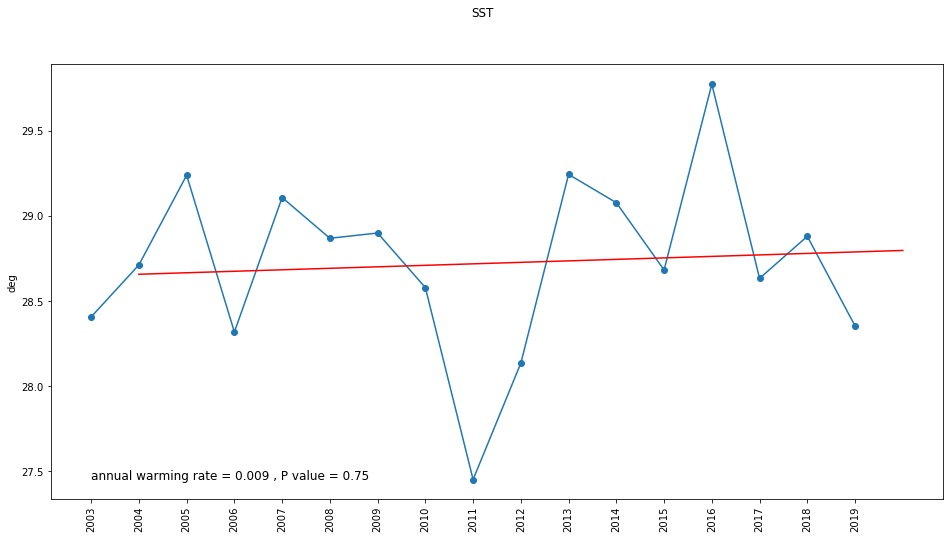

In [278]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,MaymeanISSTDF['mean'].size+1,1)
MaymeanISSTDF['ind'] = ind

MaymeanIFit = sm.ols(formula='mean ~ ind', data=MaymeanISSTDF).fit()
print(MaymeanIFit.summary())

predict = MaymeanIFit.predict(MaymeanISSTDF)
MaymeanISSTDF['fitted'] = predict

rate = round(MaymeanIFit.params[1],3)
pValue = round(MaymeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = MaymeanISSTDF.index[0]
textY = MaymeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(MaymeanISSTDF.index.values,MaymeanISSTDF['mean'].values,marker='o')


ax.plot(MaymeanISSTDF.ind, MaymeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                 -0.033
Method:                 Least Squares   F-statistic:                    0.4903
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.495
Time:                        15:31:59   Log-Likelihood:                -15.878
No. Observations:                  17   AIC:                             35.76
Df Residuals:                      15   BIC:                             37.42
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.3953      0.333     82.385      0.0

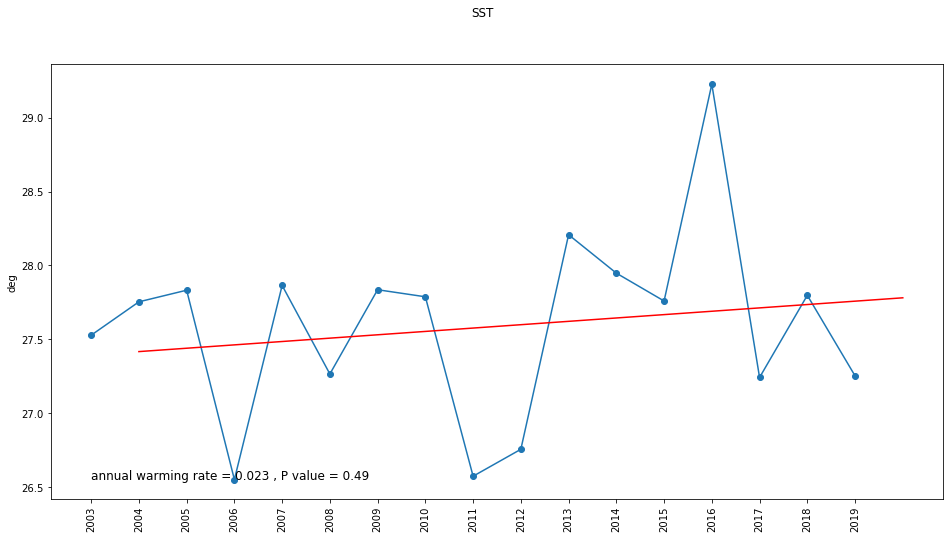

In [279]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,JunmeanISSTDF['mean'].size+1,1)
JunmeanISSTDF['ind'] = ind

JunmeanIFit = sm.ols(formula='mean ~ ind', data=JunmeanISSTDF).fit()
print(JunmeanIFit.summary())

predict = JunmeanIFit.predict(JunmeanISSTDF)
JunmeanISSTDF['fitted'] = predict

rate = round(JunmeanIFit.params[1],3)
pValue = round(JunmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = JunmeanISSTDF.index[0]
textY = JunmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(JunmeanISSTDF.index.values,JunmeanISSTDF['mean'].values,marker='o')


ax.plot(JunmeanISSTDF.ind, JunmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.075
Method:                 Least Squares   F-statistic:                     2.372
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.143
Time:                        15:31:59   Log-Likelihood:                -16.498
No. Observations:                  18   AIC:                             37.00
Df Residuals:                      16   BIC:                             38.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.4195      0.316     83.710      0.0

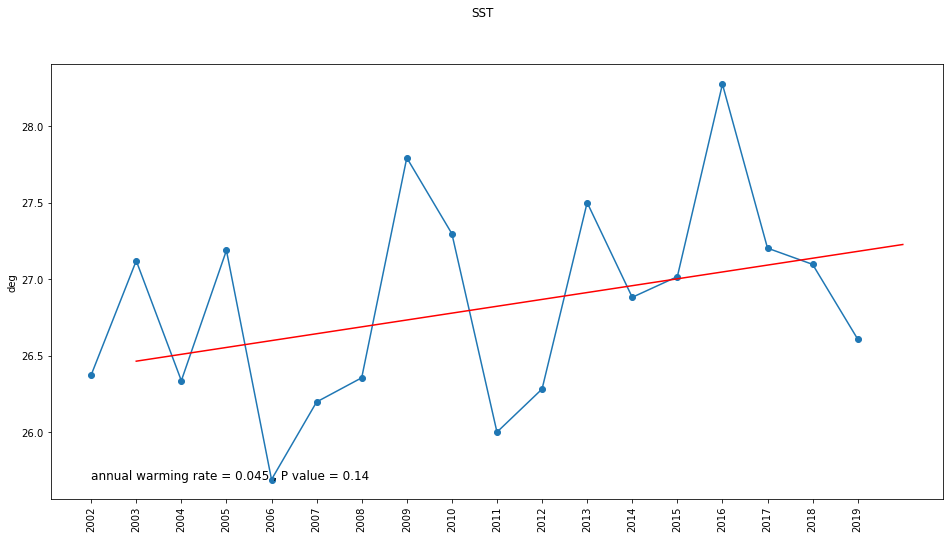

In [280]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,JulmeanISSTDF['mean'].size+1,1)
JulmeanISSTDF['ind'] = ind

JulmeanIFit = sm.ols(formula='mean ~ ind', data=JulmeanISSTDF).fit()
print(JulmeanIFit.summary())

predict = JulmeanIFit.predict(JulmeanISSTDF)
JulmeanISSTDF['fitted'] = predict

rate = round(JulmeanIFit.params[1],3)
pValue = round(JulmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = JulmeanISSTDF.index[0]
textY = JulmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(JulmeanISSTDF.index.values,JulmeanISSTDF['mean'].values,marker='o')


ax.plot(JulmeanISSTDF.ind, JulmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2.674
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.123
Time:                        15:31:59   Log-Likelihood:                -13.678
No. Observations:                  17   AIC:                             31.36
Df Residuals:                      15   BIC:                             33.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.2913      0.292     89.985      0.0

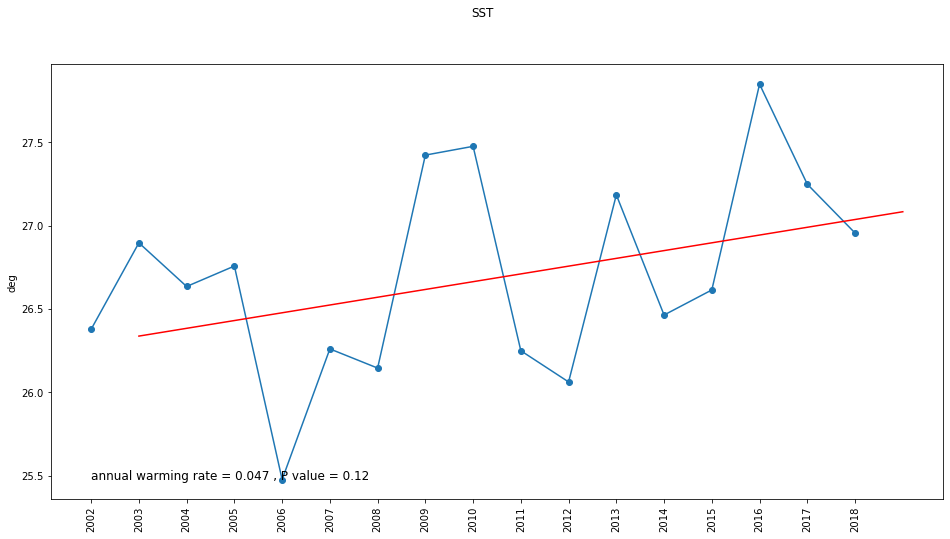

In [281]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,AugmeanISSTDF['mean'].size+1,1)
AugmeanISSTDF['ind'] = ind

AugmeanIFit = sm.ols(formula='mean ~ ind', data=AugmeanISSTDF).fit()
print(AugmeanIFit.summary())

predict = AugmeanIFit.predict(AugmeanISSTDF)
AugmeanISSTDF['fitted'] = predict

rate = round(AugmeanIFit.params[1],3)
pValue = round(AugmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = AugmeanISSTDF.index[0]
textY = AugmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(AugmeanISSTDF.index.values,AugmeanISSTDF['mean'].values,marker='o')


ax.plot(AugmeanISSTDF.ind, AugmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.101
Method:                 Least Squares   F-statistic:                     2.793
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.115
Time:                        15:12:09   Log-Likelihood:                -13.642
No. Observations:                  17   AIC:                             31.28
Df Residuals:                      15   BIC:                             32.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.2221      0.292     93.368      0.0

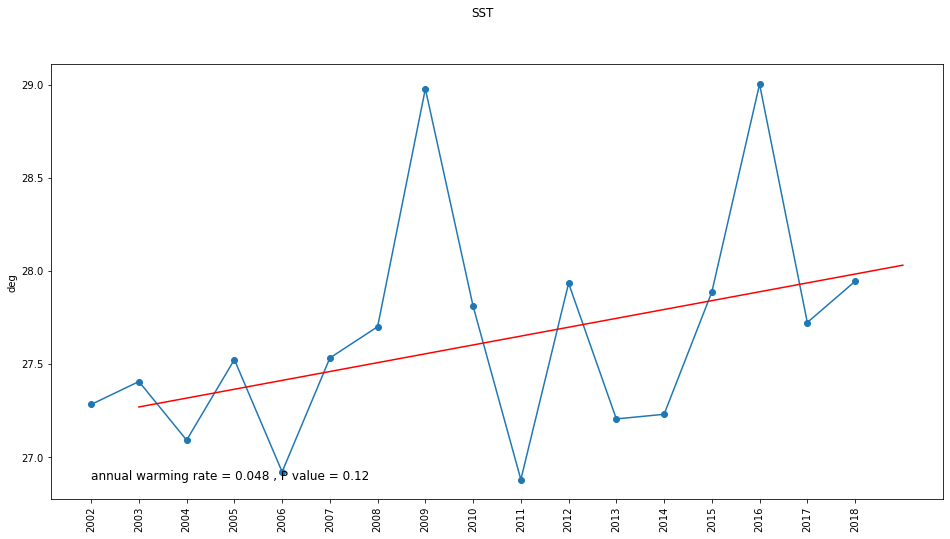

In [249]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,SepmeanISSTDF['mean'].size+1,1)
SepmeanISSTDF['ind'] = ind

SepmeanIFit = sm.ols(formula='mean ~ ind', data=SepmeanISSTDF).fit()
print(SepmeanIFit.summary())

predict = SepmeanIFit.predict(SepmeanISSTDF)
SepmeanISSTDF['fitted'] = predict

rate = round(SepmeanIFit.params[1],3)
pValue = round(SepmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = SepmeanISSTDF.index[0]
textY = SepmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(SepmeanISSTDF.index.values,SepmeanISSTDF['mean'].values,marker='o')


ax.plot(SepmeanISSTDF.ind, SepmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     1.585
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.227
Time:                        15:12:29   Log-Likelihood:                -10.564
No. Observations:                  17   AIC:                             25.13
Df Residuals:                      15   BIC:                             26.79
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.7682      0.243    118.259      0.0

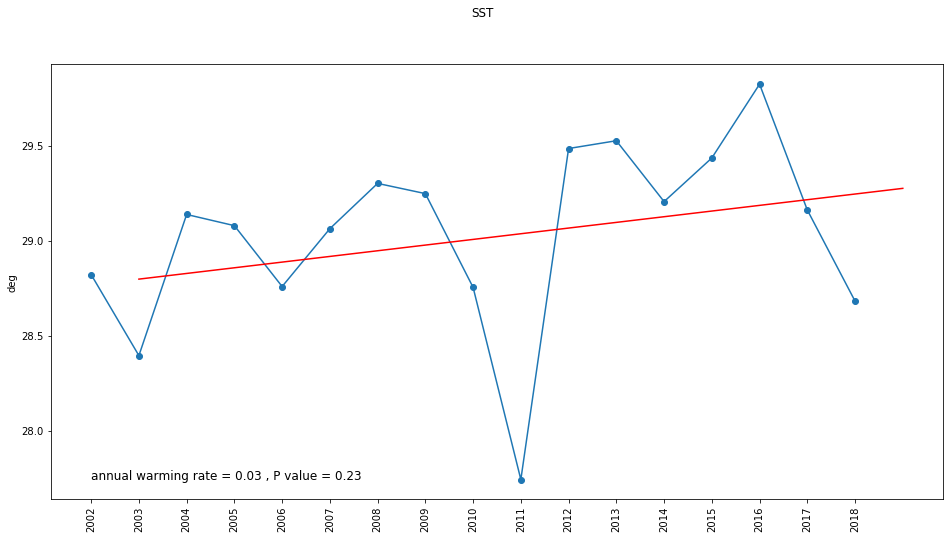

In [250]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,OctmeanISSTDF['mean'].size+1,1)
OctmeanISSTDF['ind'] = ind

OctmeanIFit = sm.ols(formula='mean ~ ind', data=OctmeanISSTDF).fit()
print(OctmeanIFit.summary())

predict = OctmeanIFit.predict(OctmeanISSTDF)
OctmeanISSTDF['fitted'] = predict

rate = round(OctmeanIFit.params[1],3)
pValue = round(OctmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = OctmeanISSTDF.index[0]
textY = OctmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(OctmeanISSTDF.index.values,OctmeanISSTDF['mean'].values,marker='o')


ax.plot(OctmeanISSTDF.ind, OctmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.118
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     2.006
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.177
Time:                        15:12:47   Log-Likelihood:                -12.095
No. Observations:                  17   AIC:                             28.19
Df Residuals:                      15   BIC:                             29.86
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.0402      0.266    112.849      0.0

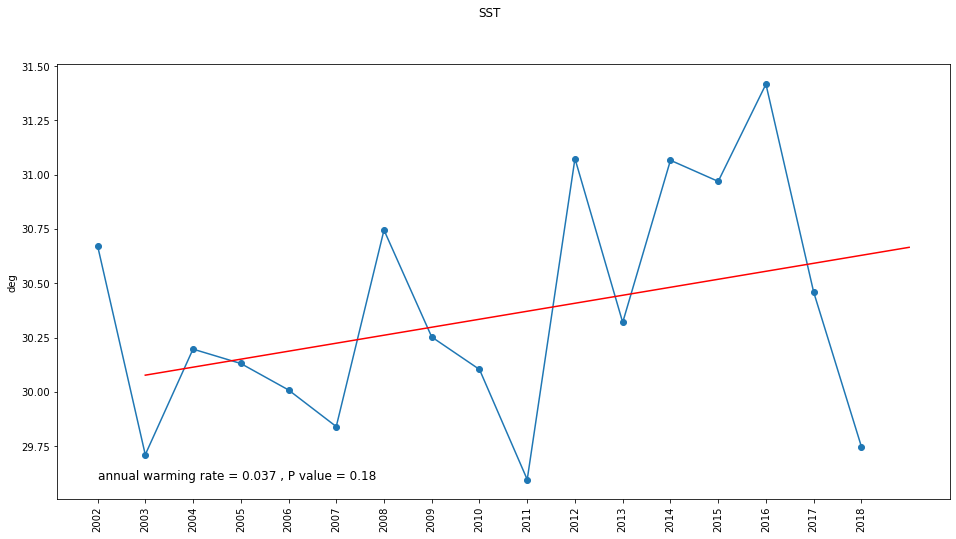

In [251]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,NovmeanISSTDF['mean'].size+1,1)
NovmeanISSTDF['ind'] = ind

NovmeanIFit = sm.ols(formula='mean ~ ind', data=NovmeanISSTDF).fit()
print(NovmeanIFit.summary())

predict = NovmeanIFit.predict(NovmeanISSTDF)
NovmeanISSTDF['fitted'] = predict

rate = round(NovmeanIFit.params[1],3)
pValue = round(NovmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = NovmeanISSTDF.index[0]
textY = NovmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(NovmeanISSTDF.index.values,NovmeanISSTDF['mean'].values,marker='o')


ax.plot(NovmeanISSTDF.ind, NovmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                 -0.051
Method:                 Least Squares   F-statistic:                    0.2213
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.645
Time:                        15:14:17   Log-Likelihood:                -15.031
No. Observations:                  17   AIC:                             34.06
Df Residuals:                      15   BIC:                             35.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     30.4297      0.316     96.181      0.0

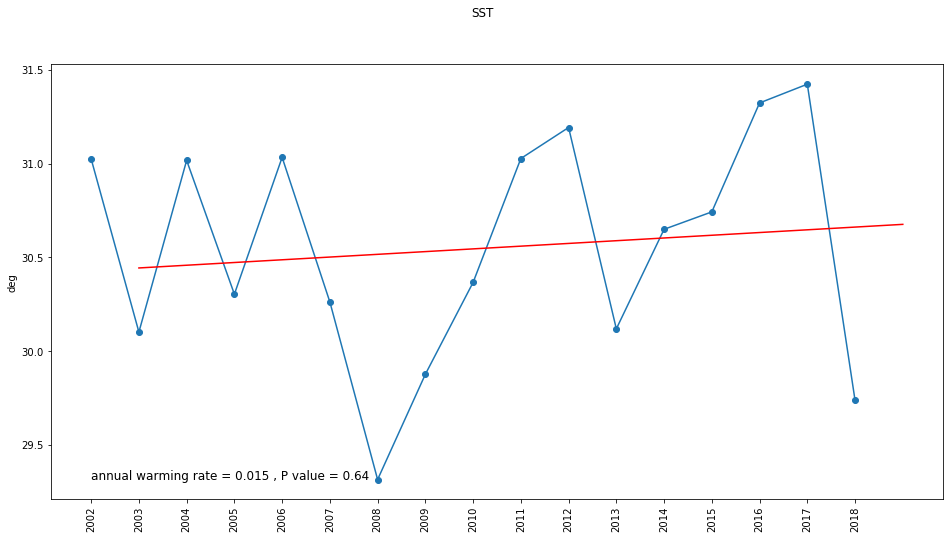

In [252]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,DecmeanISSTDF['mean'].size+1,1)
DecmeanISSTDF['ind'] = ind

DecmeanIFit = sm.ols(formula='mean ~ ind', data=DecmeanISSTDF).fit()
print(DecmeanIFit.summary())

predict = DecmeanIFit.predict(DecmeanISSTDF)
DecmeanISSTDF['fitted'] = predict

rate = round(DecmeanIFit.params[1],3)
pValue = round(DecmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = DecmeanISSTDF.index[0]
textY = DecmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(DecmeanISSTDF.index.values,DecmeanISSTDF['mean'].values,marker='o')


ax.plot(DecmeanISSTDF.ind, DecmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**annual time-series of seasonal statistics (mean, std, etc)**

In [34]:
meanIDF = sstDF[['meanI','year','season']]
x = meanIDF.groupby(['year','season'])
yearseasonmeanISSTDF = x.describe()

idx = pd.IndexSlice
SummermeanISSTDF = yearseasonmeanISSTDF.loc[idx[:,['summer']],:]
AutumnmeanISSTDF = yearseasonmeanISSTDF.loc[idx[:,['autumn']],:]
WintermeanISSTDF = yearseasonmeanISSTDF.loc[idx[:,['winter']],:]
SpringmeanISSTDF = yearseasonmeanISSTDF.loc[idx[:,['spring']],:]

SummermeanISSTDF.reset_index(inplace=True)
SummermeanISSTDF.set_index('year',inplace=True)
x = SummermeanISSTDF.columns.droplevel(level=0)
SummermeanISSTDF.columns=x
AutumnmeanISSTDF.reset_index(inplace=True)
AutumnmeanISSTDF.set_index('year',inplace=True)
x = AutumnmeanISSTDF.columns.droplevel(level=0)
AutumnmeanISSTDF.columns=x
WintermeanISSTDF.reset_index(inplace=True)
WintermeanISSTDF.set_index('year',inplace=True)
x = WintermeanISSTDF.columns.droplevel(level=0)
WintermeanISSTDF.columns=x
SpringmeanISSTDF.reset_index(inplace=True)
SpringmeanISSTDF.set_index('year',inplace=True)
x = SpringmeanISSTDF.columns.droplevel(level=0)
SpringmeanISSTDF.columns=x


SummermeanISSTDF1 = SummermeanISSTDF.loc['2003':'2018']

In [265]:
SummermeanISSTDF1

,,count,mean,std,min,25%,50%,75%,max,ind,fitted
year,,,,,,,,,,,
2003,summer,90.0,30.134249,1.075889,26.344999,29.634750,30.459709,30.793308,31.633979,2,29.847845
2004,summer,90.0,29.293002,1.602694,26.254999,28.141458,28.926009,30.744582,32.506290,3,29.833086
2005,summer,90.0,29.724508,1.078332,27.477500,29.110227,29.699221,30.431581,32.628804,4,29.818327
2006,summer,90.0,29.416857,1.429847,26.059815,28.384251,28.877896,30.863537,32.140765,5,29.803568
2007,summer,89.0,29.278101,0.909040,27.943750,28.764999,29.161458,29.972539,31.816250,6,29.788809
2008,summer,91.0,29.264835,0.585669,28.010000,28.821783,29.239672,29.578050,30.917000,7,29.774050
2009,summer,90.0,29.115985,1.017855,26.591250,28.384759,29.141247,30.009904,30.736598,8,29.759291
2010,summer,90.0,29.563448,0.980612,26.969999,28.813990,29.492046,30.630455,31.385312,9,29.744532
2011,summer,90.0,29.340475,1.568029,26.410000,28.406500,29.155300,29.857556,32.671705,10,29.729773


**plot and fit the annual time-series of seasonal mean**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.129
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     2.066
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.173
Time:                        15:25:54   Log-Likelihood:                -8.3397
No. Observations:                  16   AIC:                             20.68
Df Residuals:                      14   BIC:                             22.22
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     29.4250      0.228    128.802      0.0

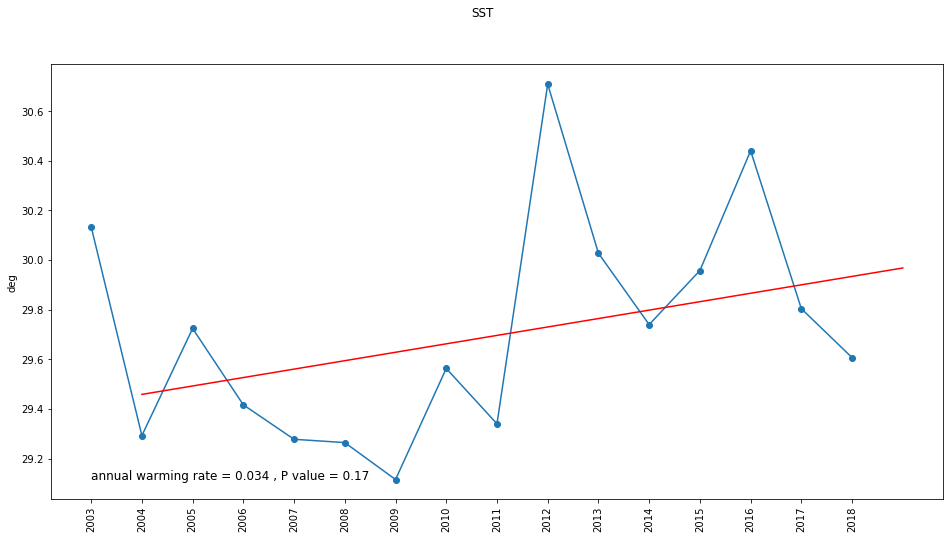

In [266]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,SummermeanISSTDF1['mean'].size+1,1)
SummermeanISSTDF1['ind'] = ind

SummermeanIFit = sm.ols(formula='mean ~ ind', data=SummermeanISSTDF1).fit()
print(SummermeanIFit.summary())

predict = SummermeanIFit.predict(SummermeanISSTDF1)
SummermeanISSTDF1['fitted'] = predict

rate = round(SummermeanIFit.params[1],3)
pValue = round(SummermeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = SummermeanISSTDF1.index[0]
textY = SummermeanISSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(SummermeanISSTDF1.index.values,SummermeanISSTDF1['mean'].values,marker='o')


ax.plot(SummermeanISSTDF1.ind, SummermeanISSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.081
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     1.327
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.267
Time:                        15:27:49   Log-Likelihood:                -16.478
No. Observations:                  17   AIC:                             36.96
Df Residuals:                      15   BIC:                             38.62
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.9338      0.344     83.995      0.0

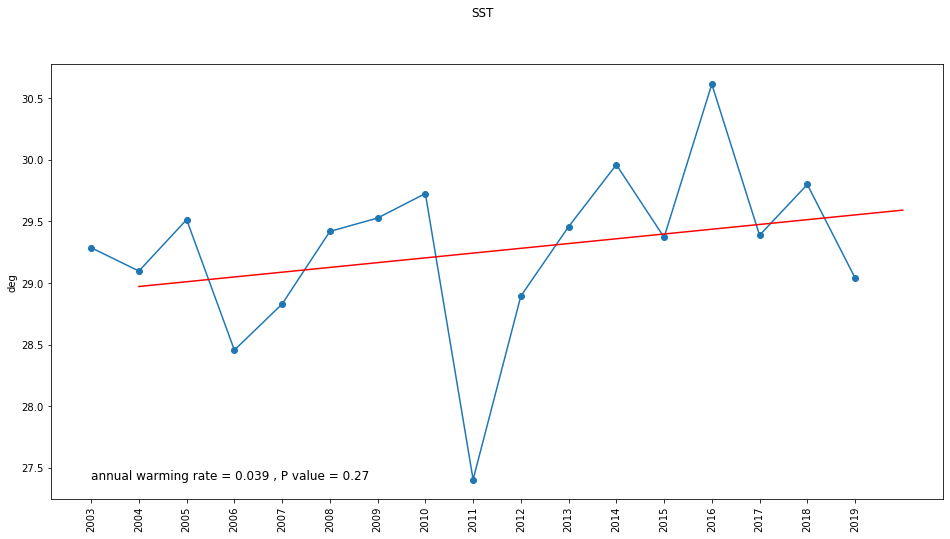

In [269]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,AutumnmeanISSTDF['mean'].size+1,1)
AutumnmeanISSTDF['ind'] = ind

AutumnmeanIFit = sm.ols(formula='mean ~ ind', data=AutumnmeanISSTDF).fit()
print(AutumnmeanIFit.summary())

predict = AutumnmeanIFit.predict(AutumnmeanISSTDF)
AutumnmeanISSTDF['fitted'] = predict

rate = round(AutumnmeanIFit.params[1],3)
pValue = round(AutumnmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = AutumnmeanISSTDF.index[0]
textY = AutumnmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(AutumnmeanISSTDF.index.values,AutumnmeanISSTDF['mean'].values,marker='o')


ax.plot(AutumnmeanISSTDF.ind, AutumnmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.133
Model:                            OLS   Adj. R-squared:                  0.071
Method:                 Least Squares   F-statistic:                     2.152
Date:                Mon, 20 Jan 2020   Prob (F-statistic):              0.164
Time:                        15:28:18   Log-Likelihood:                -13.401
No. Observations:                  16   AIC:                             30.80
Df Residuals:                      14   BIC:                             32.35
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     26.6708      0.313     85.085      0.0

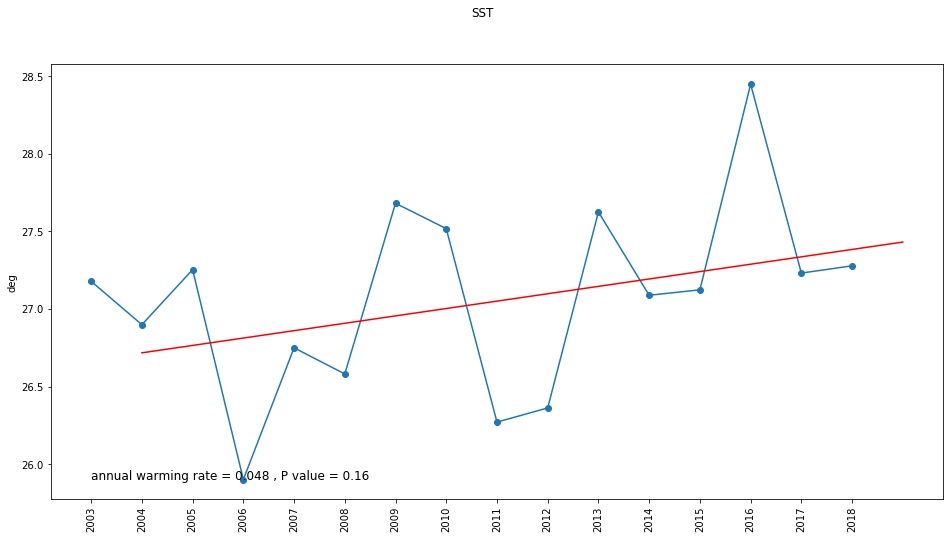

In [270]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,WintermeanISSTDF1['mean'].size+1,1)
WintermeanISSTDF1['ind'] = ind

WintermeanIFit = sm.ols(formula='mean ~ ind', data=WintermeanISSTDF1).fit()
print(WintermeanIFit.summary())

predict = WintermeanIFit.predict(WintermeanISSTDF1)
WintermeanISSTDF1['fitted'] = predict

rate = round(WintermeanIFit.params[1],3)
pValue = round(WintermeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = WintermeanISSTDF1.index[0]
textY = WintermeanISSTDF1['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(WintermeanISSTDF1.index.values,WintermeanISSTDF1['mean'].values,marker='o')


ax.plot(WintermeanISSTDF1.ind, WintermeanISSTDF1.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                   mean   R-squared:                       0.174
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     3.169
Date:                Mon, 20 Jan 2020   Prob (F-statistic):             0.0953
Time:                        15:29:13   Log-Likelihood:                -8.7531
No. Observations:                  17   AIC:                             21.51
Df Residuals:                      15   BIC:                             23.17
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.6778      0.219    131.138      0.0

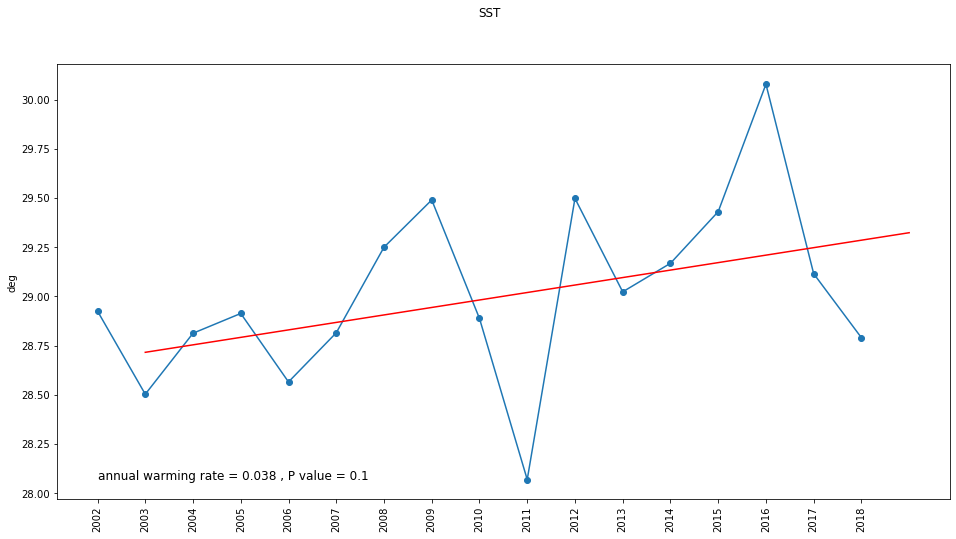

In [271]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,SpringmeanISSTDF['mean'].size+1,1)
SpringmeanISSTDF['ind'] = ind

SpringmeanIFit = sm.ols(formula='mean ~ ind', data=SpringmeanISSTDF).fit()
print(SpringmeanIFit.summary())

predict = SpringmeanIFit.predict(SpringmeanISSTDF)
SpringmeanISSTDF['fitted'] = predict

rate = round(SpringmeanIFit.params[1],3)
pValue = round(SpringmeanIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = SpringmeanISSTDF.index[0]
textY = SpringmeanISSTDF['mean'].min()
text = "annual warming rate = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(SpringmeanISSTDF.index.values,SpringmeanISSTDF['mean'].values,marker='o')


ax.plot(SpringmeanISSTDF.ind, SpringmeanISSTDF.fitted, 'r')
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

## identify extreme hot days

**trend on the number of extreme hot days each year**

**A extreme hot day is defined as a day with SST greater than the 95% percentile of the whole time-series (all days in all years)**

In [131]:
hotdaysDF = pd.DataFrame()
hotdaysList = []
yearList = sstDF.year.unique() # get unique values in a column
p95 = sstDF['meanI'].quantile(0.95) # get 95% percentile of the entire time-series
for year in yearList:    
    tempDF = sstDF[sstDF['year'] == year]
    
    hotdays = (tempDF['meanI'] > p95).sum()
   
    hotdaysList.append(hotdays)
hotdaysDF['year'] = yearList
hotdaysDF['hotdays'] = hotdaysList
hotdaysDF.set_index('year',inplace=True)

In [132]:
hotdaysDF

,hotdays
year,
2002,21
2003,7
2004,12
2005,8
2006,8
2007,3
2008,12
2009,5
2010,13


In [133]:
hotdaysDF1 = hotdaysDF.loc['2003':'2018']

**plot and fit annual time-series of number of extreme hot days**

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


                            OLS Regression Results                            
Dep. Variable:                hotdays   R-squared:                       0.380
Model:                            OLS   Adj. R-squared:                  0.335
Method:                 Least Squares   F-statistic:                     8.565
Date:                Mon, 24 Feb 2020   Prob (F-statistic):             0.0110
Time:                        16:57:11   Log-Likelihood:                -60.516
No. Observations:                  16   AIC:                             125.0
Df Residuals:                      14   BIC:                             126.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.8000      5.957      0.470      0.6

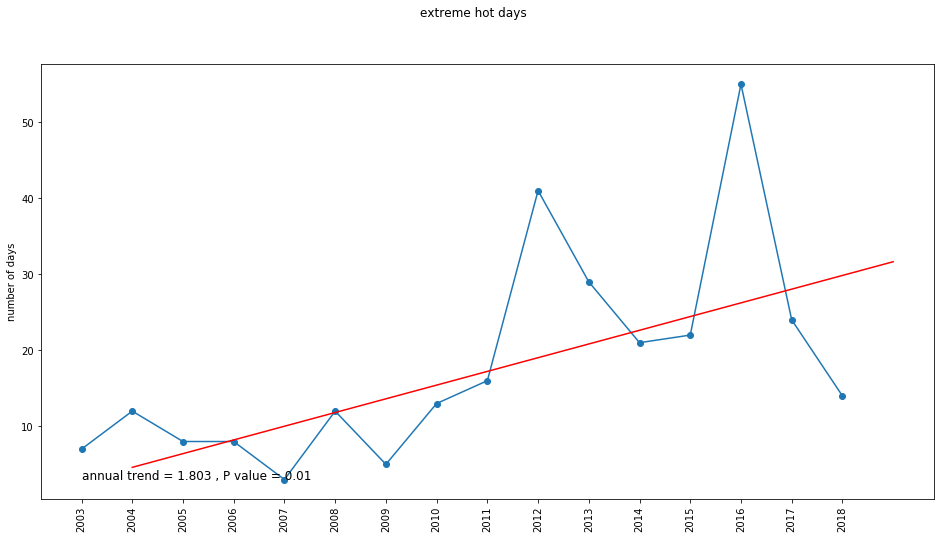

In [134]:
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.formula.api as sm
ind = np.arange(1,hotdaysDF1.index.size+1,1)
hotdaysDF1['ind'] = ind

hotdaysIFit = sm.ols(formula='hotdays ~ ind', data=hotdaysDF1).fit()
print(hotdaysIFit.summary())

predict = hotdaysIFit.predict(hotdaysDF1)
hotdaysDF1['fitted'] = predict

rate = round(hotdaysIFit.params[1],3)
pValue = round(hotdaysIFit.pvalues[1],2)

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')

textX = hotdaysDF1.index[0]
textY = hotdaysDF1['hotdays'].min()
text = "annual trend = " + str(rate) + " , P value = " + str(pValue)
plt.text(textX,textY,text,fontsize=12)
ax.plot(hotdaysDF1.index.values,hotdaysDF1['hotdays'].values,marker='o')


ax.plot(hotdaysDF1.ind, hotdaysDF1.fitted, 'r')
ax.set_ylabel('number of days')
fig.suptitle('extreme hot days')

plt.show()

In [51]:
sstDF.head(10)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,range,meanI,minI,maxI,ind,mean_fitted,min_fitted,max_fitted,year
date,,,,,,,,,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,100,26.605000,27.205000,26.917400,2691.740019,0.145534,26.910000,0.600000,26.917400,26.605000,27.205000,1,28.451962,27.776971,29.005008,2002
2002-07-05,Cartier Island,North-west,172.374499,92,25.344999,26.309999,25.874619,2380.464993,0.203260,25.850000,0.965000,25.874619,25.344999,26.309999,2,28.452060,27.777051,29.005113,2002
2002-07-06,Cartier Island,North-west,172.374499,96,26.379999,27.030001,26.698750,2563.080006,0.139280,26.702500,0.650002,26.698750,26.379999,27.030001,3,28.452158,27.777131,29.005218,2002
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.503724,26.137500,26.860001,4,28.452257,27.777211,29.005323,2002
2002-07-08,Cartier Island,North-west,172.374499,96,25.895000,26.690001,26.308698,2525.635004,0.149365,26.297501,0.795000,26.308698,25.895000,26.690001,5,28.452355,27.777291,29.005428,2002
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,26.331339,25.910000,26.707500,6,28.452453,27.777371,29.005533,2002
2002-07-10,Cartier Island,North-west,172.374499,98,25.924999,26.725000,26.353980,2582.690004,0.158531,26.365000,0.800001,26.353980,25.924999,26.725000,7,28.452551,27.777451,29.005638,2002
2002-07-11,Cartier Island,North-west,172.374499,98,25.985001,26.809999,26.338520,2581.174997,0.178426,26.290001,0.824999,26.338520,25.985001,26.809999,8,28.452649,27.777531,29.005743,2002
2002-07-12,Cartier Island,North-west,172.374499,99,25.934999,26.555000,26.243182,2598.075005,0.161215,26.245001,0.620001,26.243182,25.934999,26.555000,9,28.452748,27.777611,29.005848,2002


**The codes below try to identify the warm season, but fail due to there is a distinct and continous warm season for some years**

**one way of generating year 0203 for example**

In [52]:
year1List = []
for year in sstDF.index:
    yr = int(year[:4]+year[5:7]+year[8:10])
    if (yr >20020630) & (yr < 20030701):
        year1 = '0203'
    if (yr >20030630) & (yr < 20040701):
        year1 = '0304'
    if (yr >20040630) & (yr < 20050701):
        year1 = '0405'
    if (yr >20050630) & (yr < 20060701):
        year1 = '0506'
    if (yr >20060630) & (yr < 20070701):
        year1 = '0607'
    if (yr >20070630) & (yr < 20080701):
        year1 = '0708'
    if (yr >20080630) & (yr < 20090701):
        year1 = '0809'
    if (yr >20090630) & (yr < 20100701):
        year1 = '0910'
    if (yr >20100630) & (yr < 20110701):
        year1 = '1011'
    if (yr >20110630) & (yr < 20120701):
        year1 = '1112'
    if (yr >20120630) & (yr < 20130701):
        year1 = '1213'
    if (yr >20130630) & (yr < 20140701):
        year1 = '1314'
    if (yr >20140630) & (yr < 20150701):
        year1 = '1415'
    if (yr >20150630) & (yr < 20160701):
        year1 = '1516'
    if (yr >20160630) & (yr < 20170701):
        year1 = '1617'
    if (yr >20170630) & (yr < 20180701):
        year1 = '1718'
    if (yr >20180630) & (yr < 20190701):
        year1 = '1819'
    if (yr >20190630) & (yr < 20200701):
        year1 = '1920'
    year1List.append(year1)
sstDF['year1'] = year1List    

In [208]:
str(int('02')+1)

'3'

**another way**

In [53]:
year2List = []
for year in sstDF.index:
    a = int(year[:4])
    b = year[5:7]
    if b in ['07','08','09','10','11','12']:
        year2 = str(a) + '_' + str(a+1)
    if b in ['01','02','03','04','05','06']:
        year2 = str(a-1) + '_' + str(a)
    year2List.append(year2)
sstDF['year2'] = year2List
    

In [54]:
sstDF.head(30)

,MPA_NAME,network,area,count,min,max,mean,sum,std,median,...,meanI,minI,maxI,ind,mean_fitted,min_fitted,max_fitted,year,year1,year2
date,,,,,,,,,,,,,,,,,,,,,
2002-07-04,Cartier Island,North-west,172.374499,100,26.605000,27.205000,26.917400,2691.740019,0.145534,26.910000,...,26.917400,26.605000,27.205000,1,28.451962,27.776971,29.005008,2002,0203,2002_2003
2002-07-05,Cartier Island,North-west,172.374499,92,25.344999,26.309999,25.874619,2380.464993,0.203260,25.850000,...,25.874619,25.344999,26.309999,2,28.452060,27.777051,29.005113,2002,0203,2002_2003
2002-07-06,Cartier Island,North-west,172.374499,96,26.379999,27.030001,26.698750,2563.080006,0.139280,26.702500,...,26.698750,26.379999,27.030001,3,28.452158,27.777131,29.005218,2002,0203,2002_2003
2002-07-07,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,...,26.503724,26.137500,26.860001,4,28.452257,27.777211,29.005323,2002,0203,2002_2003
2002-07-08,Cartier Island,North-west,172.374499,96,25.895000,26.690001,26.308698,2525.635004,0.149365,26.297501,...,26.308698,25.895000,26.690001,5,28.452355,27.777291,29.005428,2002,0203,2002_2003
2002-07-09,Cartier Island,North-west,172.374499,0,NaN,NaN,NaN,NaN,NaN,NaN,...,26.331339,25.910000,26.707500,6,28.452453,27.777371,29.005533,2002,0203,2002_2003
2002-07-10,Cartier Island,North-west,172.374499,98,25.924999,26.725000,26.353980,2582.690004,0.158531,26.365000,...,26.353980,25.924999,26.725000,7,28.452551,27.777451,29.005638,2002,0203,2002_2003
2002-07-11,Cartier Island,North-west,172.374499,98,25.985001,26.809999,26.338520,2581.174997,0.178426,26.290001,...,26.338520,25.985001,26.809999,8,28.452649,27.777531,29.005743,2002,0203,2002_2003
2002-07-12,Cartier Island,North-west,172.374499,99,25.934999,26.555000,26.243182,2598.075005,0.161215,26.245001,...,26.243182,25.934999,26.555000,9,28.452748,27.777611,29.005848,2002,0203,2002_2003


In [214]:
sstDF.year2.unique()

array(['2002_2003', '2003_2004', '2004_2005', '2005_2006', '2006_2007',
       '2007_2008', '2008_2009', '2009_2010', '2010_2011', '2011_2012',
       '2012_2013', '2013_2014', '2014_2015', '2015_2016', '2016_2017',
       '2017_2018', '2018_2019', '2019_2020'], dtype=object)

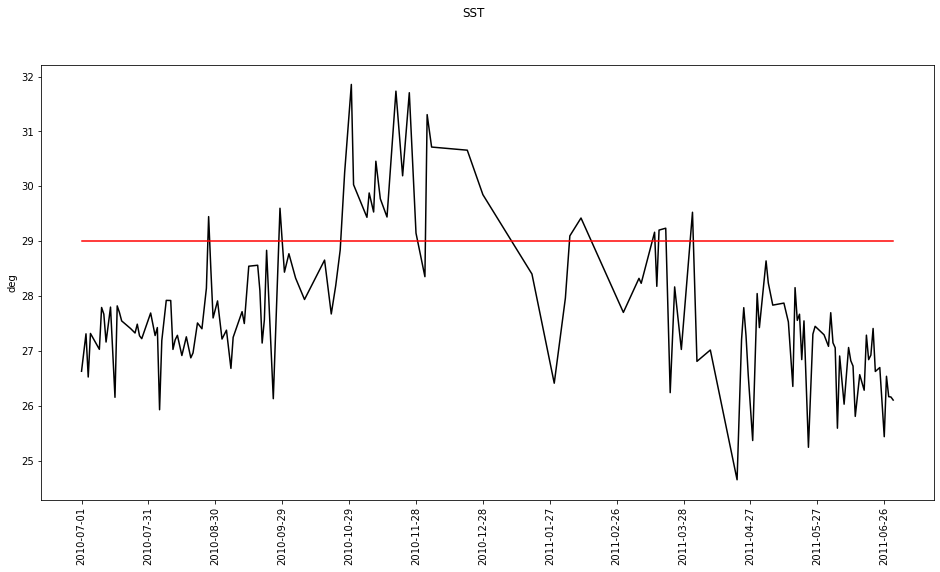

In [55]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(16,8))
plt.xticks(rotation='vertical')
sstDF_0304 = sstDF[sstDF['year2']=='2010_2011']
p75 = sstDF_0304['meanI'].describe()['75%']
p75S = np.full(sstDF_0304.index.size,p75)
ax.plot(sstDF_0304.index.values,sstDF_0304['meanI'].values,color='black')
ax.plot(sstDF_0304.index.values,p75S,color='red')
ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
ax.set_ylabel('deg')
fig.suptitle('SST')

plt.show()

**a function to return the onset date, the termination date and the duration of the warm season**

In [57]:
from datetime import datetime
def warm_season(year):    
    yearDF = sstDF[sstDF['year2']==year]
    p75 = yearDF['meanI'].describe()['75%']
    dates = yearDF[yearDF['meanI'] > p75].index
    dateList = []
    for date in dates:
        da = int(date[:4]+date[5:7]+date[8:10])
        dateList.append(da)
    minDate = min(dateList)    
    maxDate = max(dateList)
    dateformat = "%Y%m%d"
    d0 = datetime.strptime(str(minDate),dateformat)
    d1 = datetime.strptime(str(maxDate),dateformat)
    delta = d1 - d0
    return minDate,maxDate,delta.days
    

**calculating warm season time-series**

In [58]:
years = sstDF.year2.unique()
minDateList = []
maxDateList = []
deltaDaysList = []
warmSeasonDF = pd.DataFrame()
for year in years:
    minDate,maxDate,deltaDays = warm_season(year)
    minDateList.append(minDate)
    maxDateList.append(maxDate)
    deltaDaysList.append(deltaDays)
warmSeasonDF['year'] = years
warmSeasonDF['onset'] = minDateList
warmSeasonDF['termination'] = maxDateList
warmSeasonDF['noDays'] = deltaDaysList
warmSeasonDF.set_index('year',inplace=True)

In [59]:
warmSeasonDF

,onset,termination,noDays
year,,,
2002_2003,20021106,20030419,164
2003_2004,20031015,20040513,211
2004_2005,20041022,20050517,207
2005_2006,20051009,20060501,204
2006_2007,20061005,20070516,223
2007_2008,20071007,20080527,233
2008_2009,20081001,20090513,224
2009_2010,20090920,20100501,223
2010_2011,20100827,20110401,217


In [106]:
yearDF = sstDF[sstDF['year2']=='2015_2016']
p75 = yearDF['meanI'].describe()['75%']
dates = yearDF[yearDF['meanI'] > p75].index

In [107]:
dates

Index(['2015-09-20', '2015-10-24', '2015-10-25', '2015-10-26', '2015-10-30',
       '2015-10-31', '2015-11-04', '2015-11-05', '2015-11-06', '2015-11-07',
       '2015-11-14', '2015-11-15', '2015-11-19', '2015-11-20', '2015-11-21',
       '2015-11-22', '2015-11-23', '2015-11-24', '2015-11-25', '2015-11-26',
       '2015-11-27', '2015-11-28', '2015-11-29', '2015-11-30', '2015-12-03',
       '2015-12-07', '2015-12-08', '2015-12-09', '2015-12-11', '2015-12-12',
       '2015-12-13', '2015-12-14', '2015-12-15', '2015-12-16', '2015-12-17',
       '2015-12-18', '2015-12-19', '2015-12-20', '2015-12-21', '2015-12-22',
       '2016-01-07', '2016-01-10', '2016-01-16', '2016-01-17', '2016-01-19',
       '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23', '2016-02-09',
       '2016-02-10', '2016-02-21', '2016-02-22', '2016-03-05', '2016-03-06',
       '2016-03-10', '2016-03-11', '2016-03-12', '2016-03-13', '2016-03-14',
       '2016-03-15', '2016-03-16', '2016-03-19', '2016-03-20', '2016-03-21',

In [108]:
x=yearDF['meanI'] > p75

In [109]:
from scipy.ndimage import label
events,n_events = label(x)

In [110]:
events

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  2,  2,  2,  0,
        0,  0,  3,  3,  0,  0,  0,  4,  4,  4,  4,  0,  0,  0,  0,  0,  0,
        5,  5,  0,  0,  0,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        0,  0,  7,  0,  0,  0,  8,  8,  8,  0,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 10,  0,  0, 11,  0,  0,  0,  0,  0, 12, 12,  0, 13, 13,
       13, 13, 13,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0, 14, 14,  0

In [120]:
from scipy.ndimage import label
from datetime import datetime

def warm_season1(year):    
    yearDF = sstDF[sstDF['year2']==year]
    p75 = yearDF['meanI'].describe()['75%']
    x=yearDF['meanI'] > p75
    events,n_events = label(x)
    mhwE = pd.DataFrame()
    mhwE['date_start'] = []
    mhwE['date_end'] = []
    mhwE['duration'] = []
    date_start = []
    date_end = []
    duration = []
    dates = yearDF.index
    for ev in range(1,n_events+1):
        # calculate duration of an event
        event_duration = (events == ev).sum()
        # initially identify all events with duration of 4+ days
        # isolated 4-day event(s) will be eventually removed
        if event_duration > 14:    
            date_start.append(dates[np.where(events == ev)[0][0]])
            date_end.append(dates[np.where(events == ev)[0][-1]])
            duration.append(event_duration)
    # the initial list of mhwE
    mhwE['date_start'] = date_start
    mhwE['date_end'] = date_end
    mhwE['duration'] = duration
    print(mhwE.index.size)
    if mhwE.index.size > 0:
        

        # combine ajacent event(s) if they satisfy the criteria, this creates an updated list
        i = 0
        while i < mhwE.index.size - 1:

            date1 = datetime.strptime(str(mhwE.iloc[i+1]['date_start']),'%Y-%m-%d')
            date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y-%m-%d')
            gap = (date1 - date2).days

            if gap < 6:
                # condition 4: [>=5 hot, 2 cool, >=5 hot]
                if (mhwE.iloc[i]['duration'] >= 10 and mhwE.iloc[i+1]['duration'] >= 10):              
                    mhwE['date_end'][i] = mhwE['date_end'][i+1]
                    mhwE = mhwE.drop(i+1)
                    mhwE = mhwE.reset_index(drop=True)
                    i = i
                else:
                    i = i + 1
            else:
                i = i + 1

        # drop the isolated event(s) with a duration of 4 days from the list
        i = 0
        while i < mhwE.index.size:
            date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y-%m-%d')
            date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y-%m-%d')
            duration = (date2 - date1).days + 1
            if duration == 4:
                mhwE = mhwE.drop(i)
                mhwE = mhwE.reset_index(drop=True)
                i = i
            else:
                i = i + 1

        # update the durations of the final list
        i = 0
        while i < mhwE.index.size:
            date1 = datetime.strptime(str(mhwE.iloc[i]['date_start']),'%Y-%m-%d')
            date2 = datetime.strptime(str(mhwE.iloc[i]['date_end']),'%Y-%m-%d')
            duration = (date2 - date1).days + 1
            mhwE['duration'][i] = duration
            i = i + 1
        print(mhwE)
        return mhwE.loc[0].date_start,mhwE.loc[0].date_end,mhwE.loc[0].duration
    else:
        return np.nan,np.nan,np.nan
    

In [121]:
years = sstDF.year2.unique()
minDateList = []
maxDateList = []
deltaDaysList = []
warmSeasonDF1 = pd.DataFrame()
for year in years:
    print(year)
    minDate,maxDate,deltaDays = warm_season1(year)
    minDateList.append(minDate)
    maxDateList.append(maxDate)
    deltaDaysList.append(deltaDays)
warmSeasonDF1['year'] = years
warmSeasonDF1['onset'] = minDateList
warmSeasonDF1['termination'] = maxDateList
warmSeasonDF1['noDays'] = deltaDaysList
warmSeasonDF1.set_index('year',inplace=True)

2002_2003
3
   date_start    date_end  duration
0  2002-11-11  2002-11-25        15
1  2002-12-14  2002-12-30        17
2  2003-01-16  2003-02-07        23
2003_2004
2
   date_start    date_end  duration
0  2003-11-15  2003-12-28        44
2004_2005
2
   date_start    date_end  duration
0  2004-11-24  2004-12-10        17
1  2004-12-16  2005-01-02        18
2005_2006
1
   date_start    date_end  duration
0  2005-11-25  2005-12-29        35
2006_2007
1
   date_start    date_end  duration
0  2006-11-17  2007-01-05        50
2007_2008
2
   date_start    date_end  duration
0  2007-11-08  2007-11-22        15
1  2007-12-14  2007-12-29        16
2008_2009
2
   date_start    date_end  duration
0  2008-11-17  2008-12-02        16
1  2009-04-13  2009-05-05        23
2009_2010
3
   date_start    date_end  duration
0  2009-11-08  2009-11-22        15
1  2009-12-01  2009-12-17        17
2  2010-03-05  2010-03-23        19
2010_2011
2
   date_start    date_end  duration
0  2010-10-26  2011-01-09   

/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/g/data/v10/public/modules/dea-env/20191127/lib/python3.6/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


1
   date_start    date_end  duration
0  2012-12-04  2012-12-29        26
2013_2014
2
   date_start    date_end  duration
0  2013-11-05  2013-11-21        17
1  2013-12-11  2013-12-26        16
2014_2015
2
   date_start    date_end  duration
0  2014-11-04  2014-12-14        41
2015_2016
0
2016_2017
2
   date_start    date_end  duration
0  2016-10-26  2016-12-31        67
2017_2018
2
   date_start    date_end  duration
0  2017-12-02  2017-12-31        30
1  2018-04-04  2018-04-20        17
2018_2019
2
   date_start    date_end  duration
0  2018-11-03  2018-11-20        18
1  2018-12-01  2018-12-21        21
2019_2020
0


In [119]:
warmSeasonDF1

,onset,termination,noDays
year,,,
2002_2003,2002-11-11,2002-11-25,15.0
2003_2004,2003-11-15,2003-12-28,44.0
2004_2005,2004-11-24,2004-12-10,17.0
2005_2006,2005-11-25,2005-12-29,35.0
2006_2007,2006-11-17,2007-01-05,50.0
2007_2008,2007-11-08,2007-11-22,15.0
2008_2009,2008-11-17,2008-12-02,16.0
2009_2010,2009-11-08,2009-11-22,15.0
2010_2011,2010-10-26,2011-01-09,76.0
